<a href="https://colab.research.google.com/github/aaronjoel/AIPython3/blob/main/Practical_Stats_for_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pygam --quiet
!pip install dmba --quiet
!pip install imblearn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 20.9 MB/s eta 0:00:00


## Chapter 5. Classification

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np


from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression  # LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score


import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM

from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Colab environment detected.


In [ ]:
PATH = "https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data"

LOAN3000_CSV = f'{PATH}/loan3000.csv'
LOAN_DATA_CSV =f'{PATH}/loan_data.csv.gz'
FULL_TRAIN_SET_CSV = f'{PATH}/full_train_set.csv.gz'

## The Naive Solution

In [ ]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

loan_data.head()

Unnamed: 0       status  loan_amnt       term  annual_inc    dti  \
0           1  Charged Off       2500  60 months       30000   1.00   
1           2  Charged Off       5600  60 months       40000   5.55   
2           3  Charged Off       5375  60 months       15000  18.08   
3           4  Charged Off       9000  36 months       30000  10.08   
4           5  Charged Off      10000  36 months      100000   7.06   

   payment_inc_ratio  revol_bal  revol_util             purpose  ...  \
0            2.39320       1687         9.4                 car  ...   
1            4.57170       5210        32.6      small_business  ...   
2            9.71600       9279        36.5               other  ...   
3           12.21520      10452        91.7  debt_consolidation  ...   
4            3.90888      11997        55.5               other  ...   

  delinq_2yrs_zero  pub_rec_zero  open_acc  grade  outcome emp_length  \
0                1             1         3    4.8  default          1   
1                1             1        11    1.4  default          5   
2                1             1         2    6.0  default          1   
3                1             1         4    4.2  default          1   
4                1             1        14    5.4  default          4   

             purpose_ home_   emp_len_ borrower_score  
0      major_purchase  RENT   > 1 Year           0.65  
1      small_business   OWN   > 1 Year           0.80  
2               other  RENT   > 1 Year           0.60  
3  debt_consolidation  RENT   > 1 Year           0.50  
4               other  RENT   > 1 Year           0.55  

[5 rows x 21 columns]

In [ ]:
loan_data.describe()

Unnamed: 0     loan_amnt    annual_inc           dti  \
count  45342.00000  45342.000000  4.534200e+04  45342.000000   
mean   22671.50000  13154.814521  6.821170e+04     16.133731   
std    13089.25229   8088.533525  5.623902e+04      7.594881   
min        1.00000    500.000000  2.000000e+03      0.000000   
25%    11336.25000   7000.000000  4.200000e+04     10.460000   
50%    22671.50000  11500.000000  6.000000e+04     16.020000   
75%    34006.75000  18000.000000  8.100000e+04     21.590000   
max    45342.00000  35000.000000  7.141778e+06     38.860000   

       payment_inc_ratio     revol_bal    revol_util  delinq_2yrs_zero  \
count       45342.000000  4.534200e+04  45342.000000      45342.000000   
mean            8.032225  1.485745e+04     56.051800          0.857527   
std             4.264034  2.008254e+04     25.430276          0.349538   
min             0.048892  0.000000e+00      0.000000          0.000000   
25%             4.671572  5.657000e+03     37.900000          1.000000   
50%             7.499355  1.076550e+04     58.400000          1.000000   
75%            10.940575  1.861350e+04     76.400000          1.000000   
max            43.545600  1.743266e+06    128.100000          1.000000   

       pub_rec_zero      open_acc         grade    emp_length  borrower_score  
count  45342.000000  45342.000000  45342.000000  45342.000000    45342.000000  
mean       0.912090     10.413105      4.599087      6.321115        0.499006  
std        0.283167      4.696616      1.479069      3.752789        0.128687  
min        0.000000      0.000000      0.200000      0.000000        0.050000  
25%        1.000000      7.000000      3.600000      3.000000        0.400000  
50%        1.000000     10.000000      4.800000      6.000000        0.500000  
75%        1.000000     13.000000      5.800000     11.000000        0.600000  
max        1.000000     76.000000      7.000000     11.000000        1.000000

In [ ]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45342 entries, 0 to 45341
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         45342 non-null  int64  
 1   status             45342 non-null  object 
 2   loan_amnt          45342 non-null  int64  
 3   term               45342 non-null  object 
 4   annual_inc         45342 non-null  int64  
 5   dti                45342 non-null  float64
 6   payment_inc_ratio  45342 non-null  float64
 7   revol_bal          45342 non-null  int64  
 8   revol_util         45342 non-null  float64
 9   purpose            45342 non-null  object 
 10  home_ownership     45342 non-null  object 
 11  delinq_2yrs_zero   45342 non-null  int64  
 12  pub_rec_zero       45342 non-null  int64  
 13  open_acc           45342 non-null  int64  
 14  grade              45342 non-null  float64
 15  outcome            45342 non-null  object 
 16  emp_length         453

In [ ]:
## find all the categorical columns of loan_data
loan_data.select_dtypes(include=['object']).columns

Index(['status', 'term', 'purpose', 'home_ownership', 'outcome', 'purpose_',
       'home_', 'emp_len_'],
      dtype='object')

In [ ]:
# convert to categorical
loan_data['outcome'] = loan_data['outcome'].astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data['purpose_'] = loan_data['purpose_'].astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

In [ ]:
loan_data.head()

Unnamed: 0       status  loan_amnt       term  annual_inc    dti  \
0           1  Charged Off       2500  60 months       30000   1.00   
1           2  Charged Off       5600  60 months       40000   5.55   
2           3  Charged Off       5375  60 months       15000  18.08   
3           4  Charged Off       9000  36 months       30000  10.08   
4           5  Charged Off      10000  36 months      100000   7.06   

   payment_inc_ratio  revol_bal  revol_util             purpose  ...  \
0            2.39320       1687         9.4                 car  ...   
1            4.57170       5210        32.6      small_business  ...   
2            9.71600       9279        36.5               other  ...   
3           12.21520      10452        91.7  debt_consolidation  ...   
4            3.90888      11997        55.5               other  ...   

  delinq_2yrs_zero  pub_rec_zero  open_acc  grade  outcome emp_length  \
0                1             1         3    4.8  default          1   
1                1             1        11    1.4  default          5   
2                1             1         2    6.0  default          1   
3                1             1         4    4.2  default          1   
4                1             1        14    5.4  default          4   

             purpose_ home_   emp_len_ borrower_score  
0      major_purchase  RENT   > 1 Year           0.65  
1      small_business   OWN   > 1 Year           0.80  
2               other  RENT   > 1 Year           0.60  
3  debt_consolidation  RENT   > 1 Year           0.50  
4               other  RENT   > 1 Year           0.55  

[5 rows x 21 columns]

In [ ]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45342 entries, 0 to 45341
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Unnamed: 0         45342 non-null  int64   
 1   status             45342 non-null  object  
 2   loan_amnt          45342 non-null  int64   
 3   term               45342 non-null  object  
 4   annual_inc         45342 non-null  int64   
 5   dti                45342 non-null  float64 
 6   payment_inc_ratio  45342 non-null  float64 
 7   revol_bal          45342 non-null  int64   
 8   revol_util         45342 non-null  float64 
 9   purpose            45342 non-null  object  
 10  home_ownership     45342 non-null  object  
 11  delinq_2yrs_zero   45342 non-null  int64   
 12  pub_rec_zero       45342 non-null  int64   
 13  open_acc           45342 non-null  int64   
 14  grade              45342 non-null  float64 
 15  outcome            45342 non-null  category
 16  emp_

In [ ]:
predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'

pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', dtype=int)


credit_card  debt_consolidation  home_improvement  major_purchase  \
0                0                   0                 0               1   
1                0                   0                 0               0   
2                0                   0                 0               0   
3                0                   1                 0               0   
4                0                   0                 0               0   
...            ...                 ...               ...             ...   
45337            1                   0                 0               0   
45338            0                   0                 0               0   
45339            0                   1                 0               0   
45340            0                   1                 0               0   
45341            0                   1                 0               0   

       medical  other  small_business  MORTGAGE  OWN  RENT   < 1 Year  \
0            0      0               0         0    0     1          0   
1            0      0               1         0    1     0          0   
2            0      1               0         0    0     1          0   
3            0      0               0         0    0     1          0   
4            0      1               0         0    0     1          0   
...        ...    ...             ...       ...  ...   ...        ...   
45337        0      0               0         0    0     1          0   
45338        0      1               0         1    0     0          0   
45339        0      0               0         1    0     0          0   
45340        0      0               0         1    0     0          0   
45341        0      0               0         1    0     0          0   

        > 1 Year  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
45337          1  
45338          1  
45339          1  
45340          1  
45341          1  

[45342 rows x 12 columns]

In [ ]:
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', dtype=int)
X

credit_card  debt_consolidation  home_improvement  major_purchase  \
0                0                   0                 0               1   
1                0                   0                 0               0   
2                0                   0                 0               0   
3                0                   1                 0               0   
4                0                   0                 0               0   
...            ...                 ...               ...             ...   
45337            1                   0                 0               0   
45338            0                   0                 0               0   
45339            0                   1                 0               0   
45340            0                   1                 0               0   
45341            0                   1                 0               0   

       medical  other  small_business  MORTGAGE  OWN  RENT   < 1 Year  \
0            0      0               0         0    0     1          0   
1            0      0               1         0    1     0          0   
2            0      1               0         0    0     1          0   
3            0      0               0         0    0     1          0   
4            0      1               0         0    0     1          0   
...        ...    ...             ...       ...  ...   ...        ...   
45337        0      0               0         0    0     1          0   
45338        0      1               0         1    0     0          0   
45339        0      0               0         1    0     0          0   
45340        0      0               0         1    0     0          0   
45341        0      0               0         1    0     0          0   

        > 1 Year  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
45337          1  
45338          1  
45339          1  
45340          1  
45341          1  

[45342 rows x 12 columns]

In [ ]:
y = loan_data[outcome]
y

0         default
1         default
2         default
3         default
4         default
           ...   
45337    paid off
45338    paid off
45339    paid off
45340    paid off
45341    paid off
Name: outcome, Length: 45342, dtype: category
Categories (2, object): ['default', 'paid off']

In [ ]:
naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model

MultinomialNB(alpha=0.01)

In [ ]:
naive_model = MultinomialNB(alpha=1e-10, fit_prior=False)
naive_model

MultinomialNB(alpha=1e-10, fit_prior=False)

In [ ]:
naive_model.fit(X, y)

MultinomialNB(alpha=1e-10, fit_prior=False)

In [ ]:
new_loan = X.loc[146:146, :]
new_loan

credit_card  debt_consolidation  home_improvement  major_purchase  \
146            0                   0                 0               0   

     medical  other  small_business  MORTGAGE  OWN  RENT   < 1 Year   > 1 Year  
146        0      0               1         1    0     0          0          1

In [ ]:
print(f'predicted class: {naive_model.predict(new_loan)[0]}')

predicted class: default


In [ ]:
probabilities = pd.DataFrame(naive_model.predict_proba(X),
                             columns=naive_model.classes_)

probabilities

default  paid off
0      0.435846  0.564154
1      0.688002  0.311998
2      0.562448  0.437552
3      0.536658  0.463342
4      0.562448  0.437552
...         ...       ...
45337  0.472905  0.527095
45338  0.500662  0.499338
45339  0.474632  0.525368
45340  0.474632  0.525368
45341  0.474632  0.525368

[45342 rows x 2 columns]

In [ ]:
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
probabilities

default  paid off
0  0.653699  0.346301

In [ ]:
loan3000 = pd.read_csv(LOAN3000_CSV)
loan3000.head()

Unnamed: 0   outcome            purpose_    dti  borrower_score  \
0       32109  paid off  debt_consolidation  21.23            0.40   
1       16982   default         credit_card  15.49            0.40   
2       25335  paid off  debt_consolidation  27.30            0.70   
3       34580  paid off      major_purchase  21.11            0.40   
4       14424   default  debt_consolidation  16.46            0.45   

   payment_inc_ratio  
0            5.11135  
1            5.43165  
2            9.23003  
3            2.33482  
4           12.10320

In [ ]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

In [ ]:
X.head()

borrower_score  payment_inc_ratio
0            0.40            5.11135
1            0.40            5.43165
2            0.70            9.23003
3            0.40            2.33482
4            0.45           12.10320

In [ ]:
loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

pd.DataFrame(loan_lda.scalings_, index=X.columns)

0
borrower_score     7.175839
payment_inc_ratio -0.099676

In [ ]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)

pred.head()

default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048

In [ ]:
# Use scalings and center of means to determine boundary
center = np.mean(loan_lda.means_, axis=0)
slope = -loan_lda.scalings_[0] / loan_lda.scalings_[1]
slope

array([71.99193766])

In [ ]:
intercept = center[1] - center[0] * slope
intercept

array([-27.89978562])

In [ ]:
# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_0

array([0.38754042])

In [ ]:
x_20 = (20 - intercept) / slope
x_20

array([0.6653493])

In [ ]:
lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

Unnamed: 0   outcome            purpose_    dti  borrower_score  \
0       32109  paid off  debt_consolidation  21.23            0.40   
1       16982   default         credit_card  15.49            0.40   
2       25335  paid off  debt_consolidation  27.30            0.70   
3       34580  paid off      major_purchase  21.11            0.40   
4       14424   default  debt_consolidation  16.46            0.45   

   payment_inc_ratio   default  
0            5.11135  0.553544  
1            5.43165  0.558953  
2            9.23003  0.272696  
3            2.33482  0.506254  
4           12.10320  0.609952

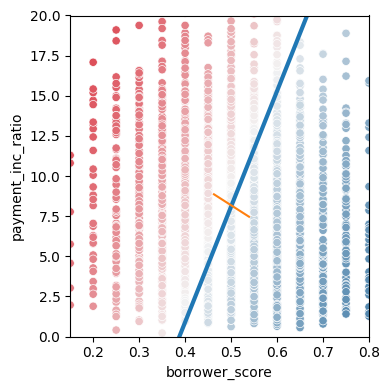

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df,
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)


ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)

ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

In [ ]:
loan_lda.means_.transpose()

array([[0.46280277, 0.53906752],
       [8.86181347, 7.4651989 ]])

## Logistic regression

### Logistic Response Function and Logit

In [ ]:
p = np.arange(0.01, 1, 0.01)
p

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [ ]:
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p)
})

df

p     logit       odds
0   0.01 -4.595120   0.010101
1   0.02 -3.891820   0.020408
2   0.03 -3.476099   0.030928
3   0.04 -3.178054   0.041667
4   0.05 -2.944439   0.052632
..   ...       ...        ...
94  0.95  2.944439  19.000000
95  0.96  3.178054  24.000000
96  0.97  3.476099  32.333333
97  0.98  3.891820  49.000000
98  0.99  4.595120  99.000000

[99 rows x 3 columns]

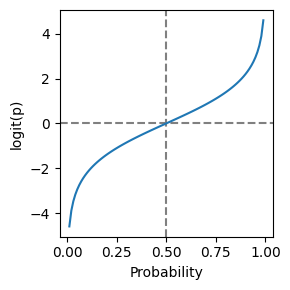

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

In [ ]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 'borrower_score']

outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='',
                   drop_first=True, dtype=int)

X

payment_inc_ratio  borrower_score  debt_consolidation  \
0                2.39320            0.65                   0   
1                4.57170            0.80                   0   
2                9.71600            0.60                   0   
3               12.21520            0.50                   1   
4                3.90888            0.55                   0   
...                  ...             ...                 ...   
45337            4.57850            0.35                   0   
45338            3.20333            0.50                   0   
45339            9.98460            0.55                   1   
45340            6.45250            0.65                   1   
45341           11.87150            0.50                   1   

       home_improvement  major_purchase  medical  other  small_business  OWN  \
0                     0               1        0      0               0    0   
1                     0               0        0      0               1    1   
2                     0               0        0      1               0    0   
3                     0               0        0      0               0    0   
4                     0               0        0      1               0    0   
...                 ...             ...      ...    ...             ...  ...   
45337                 0               0        0      0               0    0   
45338                 0               0        0      1               0    0   
45339                 0               0        0      0               0    0   
45340                 0               0        0      0               0    0   
45341                 0               0        0      0               0    0   

       RENT   > 1 Year  
0         1          1  
1         0          1  
2         1          1  
3         1          1  
4         1          1  
...     ...        ...  
45337     1          1  
45338     0          1  
45339     0          1  
45340     0          1  
45341     0          1  

[45342 rows x 11 columns]

In [ ]:
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

LogisticRegression(C=1e+42, solver='liblinear')

In [ ]:
print(f'Intercept: {logit_reg.intercept_[0]}')
print(f'classes: {logit_reg.classes_}')

pd.DataFrame({'coeff': logit_reg.coef_[0]},
             index=X.columns)

Intercept: -1.6380882883923482
classes: ['default' 'paid off']


coeff
payment_inc_ratio  -0.079728
borrower_score      4.611037
debt_consolidation -0.249342
home_improvement   -0.407614
major_purchase     -0.229376
medical            -0.510087
other              -0.620534
small_business     -1.215662
OWN                -0.048453
RENT               -0.157355
 > 1 Year           0.357463

In [ ]:
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

Index(['credit_card', 'debt_consolidation', 'home_improvement',
       'major_purchase', 'medical', 'other', 'small_business'],
      dtype='object')
Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')
Index([' < 1 Year', ' > 1 Year'], dtype='object')


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

y_enc

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
logit_reg_enc = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

LogisticRegression(C=1e+42, solver='liblinear')

In [ ]:
print(f'Intercept: {logit_reg_enc.intercept_[0]}')
print(f'classes: {logit_reg_enc.classes_}')

pd.DataFrame({'coeff': logit_reg_enc.coef_[0]},
             index=X.columns)

Intercept: 1.6378909416318836
classes: [0. 1.]


coeff
payment_inc_ratio   0.079739
borrower_score     -4.612183
debt_consolidation  0.249414
home_improvement    0.407734
major_purchase      0.229710
medical             0.510744
other               0.620800
small_business      1.214936
OWN                 0.048211
RENT                0.157288
 > 1 Year          -0.356794

In [ ]:
logit_reg.predict_log_proba(X)

array([[-1.41674603, -0.27773416],
       [-1.15706611, -0.37747151],
       [-0.66043357, -0.72696727],
       ...,
       [-0.80367524, -0.59362879],
       [-1.27894673, -0.32618773],
       [-0.61132301, -0.78226802]])

In [ ]:
logit_reg.classes_

array(['default', 'paid off'], dtype=object)

In [ ]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)


pred.head()

default  paid off
0  0.242502  0.757498
1  0.314407  0.685593
2  0.516627  0.483373
3  0.588000  0.412000
4  0.458618  0.541382

In [ ]:
pred.describe()

default      paid off
count  45342.000000  45342.000000
mean       0.500001      0.499999
std        0.167336      0.167336
min        0.062733      0.029046
25%        0.373167      0.376377
50%        0.497895      0.502105
75%        0.623623      0.626833
max        0.970954      0.937267

In [ ]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)

pred

default  paid off
0      0.242502  0.757498
1      0.314407  0.685593
2      0.516627  0.483373
3      0.588000  0.412000
4      0.458618  0.541382
...         ...       ...
45337  0.547148  0.452852
45338  0.462828  0.537172
45339  0.447681  0.552319
45340  0.278330  0.721670
45341  0.542632  0.457368

[45342 rows x 2 columns]

In [ ]:
pred.describe()

default      paid off
count  45342.000000  45342.000000
mean       0.500001      0.499999
std        0.167336      0.167336
min        0.062733      0.029046
25%        0.373167      0.376377
50%        0.497895      0.502105
75%        0.623623      0.626833
max        0.970954      0.937267

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')

ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)

plt.tight_layout()
plt.show()

In [ ]:
# use GLM (general linear model) with the binomial family to
# fit a logistic regression
y_numbers = [1 if yi == 'default' else 0 for yi in y]
y_numbers[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1),
                      family=sm.families.Binomial())

logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Sun, 21 Jul 2024   Deviance:                       57515.
Time:                        09:59:33   Pearson chi2:                 4.54e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1112
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0

In [ ]:
import statsmodels.formula.api as smf

formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')

model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Sun, 21 Jul 2024   Deviance:                       57462.
Time:                                               09:59:34   Pearson chi2:                 4.54e+04
No. Iterations:                                            6   Pseudo R-squ. (CS):             0.1122
Covariance Type:                                   nonrobust                      

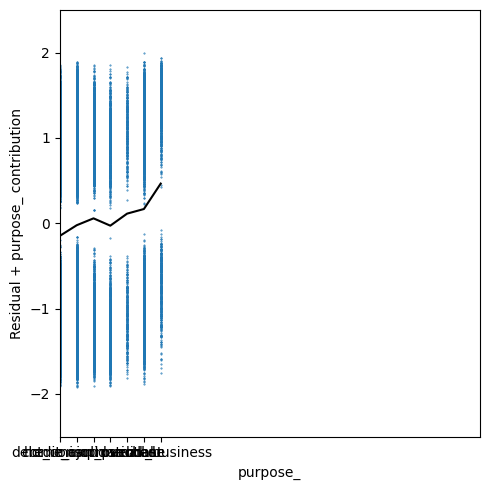

In [ ]:
from statsmodels.genmod.generalized_linear_model import GLMResults

def partialResidualPlot(model, df, outcome, feature, fig, ax):
  y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
  y_pred = model.predict(df)

  org_params = model.params.copy()
  zero_params = model.params.copy()

  # set model parameters of other features to 0
  for i, name in enumerate(zero_params.index):
    if feature in name:
        continue
    zero_params[i] = 0.0

  model.initialize(model.model, zero_params)

  feature_prediction = model.predict(df)

  ypartial = -np.log(1 / feature_prediction - 1)
  ypartial = ypartial - np.mean(ypartial)

  model.initialize(model.model, org_params)

  results = pd.DataFrame({
      'feature': df[feature],
      'residual': -2*(y_actual - y_pred),
      'ypartial': ypartial/2
  })

  results = results.sort_values(by=['feature'])

  ax.scatter(results.feature, results.residual, marker='.', s=72./fig.dpi)
  ax.plot(results.feature, results.ypartial, color='black')
  ax.set_xlabel(feature)
  ax.set_ylabel(f'Residual + {feature} contribution')

  return ax

fig, ax = plt.subplots(figsize=(5, 5))

partialResidualPlot(results, loan_data, 'outcome', 'purpose_', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()

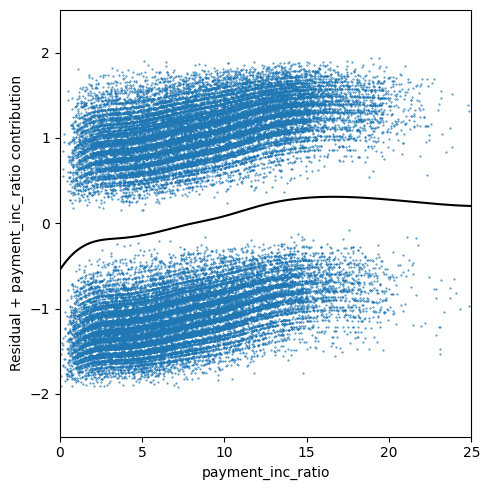

In [ ]:
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)


plt.tight_layout()
plt.show()

In [ ]:
results

In [ ]:
y_actual = [0 if s == 'default' else 1 for s in loan_data['outcome']]
y_actual[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
y_pred = results.predict(loan_data)
y_pred

0        0.257341
1        0.288283
2        0.525174
3        0.606843
4        0.460321
           ...   
45337    0.533534
45338    0.469331
45339    0.452835
45340    0.276884
45341    0.559683
Length: 45342, dtype: float64

In [ ]:
org_params = results.params.copy()
org_params

Intercept                         1.575614
purpose_[T.debt_consolidation]    0.248631
purpose_[T.home_improvement]      0.409708
purpose_[T.major_purchase]        0.238236
purpose_[T.medical]               0.520559
purpose_[T.other]                 0.628437
purpose_[T.small_business]        1.224953
home_[T.OWN]                      0.049812
home_[T.RENT]                     0.157661
emp_len_[T. > 1 Year]            -0.352614
bs(payment_inc_ratio, df=8)[0]    0.704167
bs(payment_inc_ratio, df=8)[1]    0.662121
bs(payment_inc_ratio, df=8)[2]    0.811784
bs(payment_inc_ratio, df=8)[3]    1.037710
bs(payment_inc_ratio, df=8)[4]    1.190148
bs(payment_inc_ratio, df=8)[5]    2.840399
bs(payment_inc_ratio, df=8)[6]   -1.342667
bs(payment_inc_ratio, df=8)[7]    7.109363
bs(borrower_score, df=3)[0]      -2.901130
bs(borrower_score, df=3)[1]      -2.605644
bs(borrower_score, df=3)[2]      -5.742075
dtype: float64

In [ ]:
zero_params = results.params.copy()
zero_params

Intercept                         1.575614
purpose_[T.debt_consolidation]    0.248631
purpose_[T.home_improvement]      0.409708
purpose_[T.major_purchase]        0.238236
purpose_[T.medical]               0.520559
purpose_[T.other]                 0.628437
purpose_[T.small_business]        1.224953
home_[T.OWN]                      0.049812
home_[T.RENT]                     0.157661
emp_len_[T. > 1 Year]            -0.352614
bs(payment_inc_ratio, df=8)[0]    0.704167
bs(payment_inc_ratio, df=8)[1]    0.662121
bs(payment_inc_ratio, df=8)[2]    0.811784
bs(payment_inc_ratio, df=8)[3]    1.037710
bs(payment_inc_ratio, df=8)[4]    1.190148
bs(payment_inc_ratio, df=8)[5]    2.840399
bs(payment_inc_ratio, df=8)[6]   -1.342667
bs(payment_inc_ratio, df=8)[7]    7.109363
bs(borrower_score, df=3)[0]      -2.901130
bs(borrower_score, df=3)[1]      -2.605644
bs(borrower_score, df=3)[2]      -5.742075
dtype: float64

In [ ]:
zero_params.index

Index(['Intercept', 'purpose_[T.debt_consolidation]',
       'purpose_[T.home_improvement]', 'purpose_[T.major_purchase]',
       'purpose_[T.medical]', 'purpose_[T.other]',
       'purpose_[T.small_business]', 'home_[T.OWN]', 'home_[T.RENT]',
       'emp_len_[T. > 1 Year]', 'bs(payment_inc_ratio, df=8)[0]',
       'bs(payment_inc_ratio, df=8)[1]', 'bs(payment_inc_ratio, df=8)[2]',
       'bs(payment_inc_ratio, df=8)[3]', 'bs(payment_inc_ratio, df=8)[4]',
       'bs(payment_inc_ratio, df=8)[5]', 'bs(payment_inc_ratio, df=8)[6]',
       'bs(payment_inc_ratio, df=8)[7]', 'bs(borrower_score, df=3)[0]',
       'bs(borrower_score, df=3)[1]', 'bs(borrower_score, df=3)[2]'],
      dtype='object')

In [ ]:
for i, name in enumerate(zero_params.index):
  if 'payment_inc_ratio' in name:
    continue
  zero_params[i] = 0.0

In [ ]:
zero_params

Intercept                         0.000000
purpose_[T.debt_consolidation]    0.000000
purpose_[T.home_improvement]      0.000000
purpose_[T.major_purchase]        0.000000
purpose_[T.medical]               0.000000
purpose_[T.other]                 0.000000
purpose_[T.small_business]        0.000000
home_[T.OWN]                      0.000000
home_[T.RENT]                     0.000000
emp_len_[T. > 1 Year]             0.000000
bs(payment_inc_ratio, df=8)[0]    0.704167
bs(payment_inc_ratio, df=8)[1]    0.662121
bs(payment_inc_ratio, df=8)[2]    0.811784
bs(payment_inc_ratio, df=8)[3]    1.037710
bs(payment_inc_ratio, df=8)[4]    1.190148
bs(payment_inc_ratio, df=8)[5]    2.840399
bs(payment_inc_ratio, df=8)[6]   -1.342667
bs(payment_inc_ratio, df=8)[7]    7.109363
bs(borrower_score, df=3)[0]       0.000000
bs(borrower_score, df=3)[1]       0.000000
bs(borrower_score, df=3)[2]       0.000000
dtype: float64

In [ ]:
results.initialize(results.model, zero_params)

In [ ]:
feature_prediction = results.predict(loan_data)
feature_prediction

0        0.659883
1        0.680080
2        0.768959
3        0.814602
4        0.673161
           ...   
45337    0.680165
45338    0.668445
45339    0.773785
45340    0.712980
45341    0.809022
Length: 45342, dtype: float64

In [ ]:
ypartial = -np.log(1 / feature_prediction - 1)
ypartial

0        0.662771
1        0.754140
2        1.202441
3        1.480196
4        0.722515
           ...   
45337    0.754531
45338    0.701159
45339    1.229809
45340    0.909903
45341    1.443669
Length: 45342, dtype: float64

In [ ]:
ypartial = ypartial - np.mean(ypartial)
ypartial

0       -0.400635
1       -0.309266
2        0.139035
3        0.416791
4       -0.340890
           ...   
45337   -0.308875
45338   -0.362247
45339    0.166404
45340   -0.153502
45341    0.380264
Length: 45342, dtype: float64

In [ ]:
res = pd.DataFrame({
    'feature': loan_data['payment_inc_ratio'],
    'residual': -2 * (y_actual - y_pred),
    'ypartial': ypartial / 2,
})

res

feature  residual  ypartial
0       2.39320  0.514682 -0.200317
1       4.57170  0.576565 -0.154633
2       9.71600  1.050348  0.069518
3      12.21520  1.213687  0.208396
4       3.90888  0.920642 -0.170445
...         ...       ...       ...
45337   4.57850 -0.932932 -0.154437
45338   3.20333 -1.061338 -0.181123
45339   9.98460 -1.094331  0.083202
45340   6.45250 -1.446231 -0.076751
45341  11.87150 -0.880634  0.190132

[45342 rows x 3 columns]

In [ ]:
res = res.sort_values(by=['feature'])
res

feature  residual  ypartial
24308   0.048892 -1.785102 -0.531703
38294   0.081684 -1.904835 -0.522295
29630   0.084063 -1.531199 -0.521619
40266   0.113196 -1.478478 -0.513420
43052   0.117402 -1.398048 -0.512247
...          ...       ...       ...
4936   28.575700  1.473133  0.234969
5231   29.755800  1.582602  0.277215
40471  32.989600 -0.329178  0.505605
6052   33.630900  1.852828  0.574099
6007   43.545600  1.996060  3.022979

[45342 rows x 3 columns]

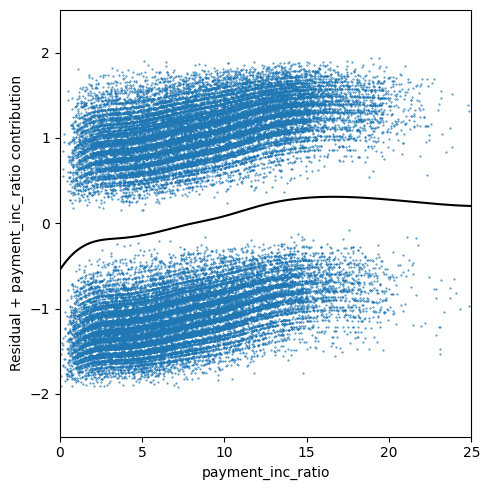

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(res.feature, res.residual, marker='.', s=72./fig.dpi)
ax.plot(res.feature, res.ypartial, color='black')
ax.set_xlabel('payment_inc_ratio')
ax.set_ylabel('Residual + payment_inc_ratio contribution')


ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()

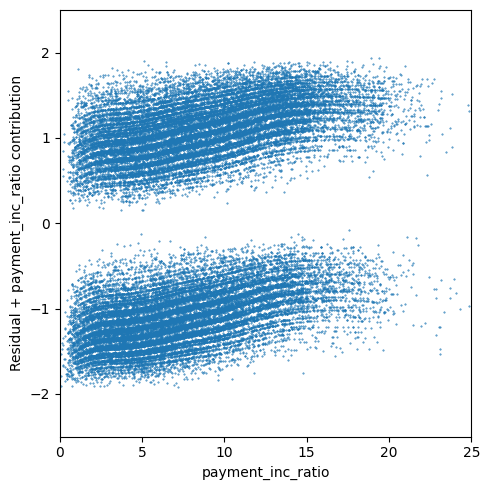

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(res.feature, res.residual, marker='.', s=72./fig.dpi)
#ax.plot(res.feature, res.ypartial, color='black')
ax.set_xlabel('payment_inc_ratio')
ax.set_ylabel('Residual + payment_inc_ratio contribution')


ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()

In [ ]:
# Confusion matrix
pred = logit_reg.predict(X)
pred

array(['paid off', 'paid off', 'default', ..., 'paid off', 'paid off',
       'default'], dtype=object)

In [ ]:
pred_y = logit_reg.predict(X) == 'default'
pred_y

array([False, False,  True, ..., False, False,  True])

In [ ]:
true_y = (y == 'default')
true_y[:10]

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
Name: outcome, dtype: bool

In [ ]:
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

In [ ]:
conf_mat = pd.DataFrame(
    [[np.sum(true_pos), np.sum(false_neg)],
     [np.sum(false_pos), np.sum(true_neg)]],
    index=['Y = default', 'Y = paid off'],
    columns=['Yhat = default', 'Yhat = paid off']
)

conf_mat

Yhat = default  Yhat = paid off
Y = default            14336             8335
Y = paid off            8148            14523

In [ ]:
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14336             8335
Y = paid off            8148            14523


In [ ]:
confusion_matrix(y, logit_reg.predict(X))

array([[14336,  8335],
       [ 8148, 14523]])

In [ ]:
classificationSummary(y, logit_reg.predict(X),
                      class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.6365)

         Prediction
  Actual  default paid off
 default    14336     8335
paid off     8148    14523


In [ ]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
conf_mat

array([[14336,  8335],
       [ 8148, 14523]])

In [ ]:
print(f'Precision:   {conf_mat[0, 0] / sum(conf_mat[:, 0])}')
print(f'Recall:      {conf_mat[0, 0] / sum(conf_mat[0, :])}')
print(f'Specificity: {conf_mat[1, 1] / sum(conf_mat[1, :])}')

Precision:   0.6376089663760897
Recall:      0.6323496978518812
Specificity: 0.6405981209474659


In [ ]:
precision_recall_fscore_support(y, logit_reg.predict(X),
                                labels=['default', 'paid off'])

(array([0.63760897, 0.63535742]),
 array([0.6323497 , 0.64059812]),
 array([0.63496844, 0.63796701]),
 array([22671, 22671]))

In [ ]:
fpr, tpr, thresholds = roc_curve(y,
                                 logit_reg.predict_proba(X)[:, 0],
                                 pos_label='default')

fpr

array([0.        , 0.        , 0.        , ..., 0.99872083, 0.99872083,
       1.        ])

In [ ]:
tpr

array([0.00000000e+00, 4.41092144e-05, 1.32327643e-04, ...,
       9.99955891e-01, 1.00000000e+00, 1.00000000e+00])

In [ ]:
thresholds

array([1.97095372, 0.97095372, 0.96688761, ..., 0.09864163, 0.09806258,
       0.06273269])

In [ ]:
roc_df = pd.DataFrame({
    'recall': tpr,
    'specificity': 1 - fpr
})

roc_df

recall  specificity
0      0.000000     1.000000
1      0.000044     1.000000
2      0.000132     1.000000
3      0.000132     0.999956
4      0.000265     0.999956
...         ...          ...
20183  0.999912     0.001367
20184  0.999956     0.001367
20185  0.999956     0.001279
20186  1.000000     0.001279
20187  1.000000     0.000000

[20188 rows x 2 columns]

In [ ]:
ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')

plt.tight_layout()
plt.show()

In [ ]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:, 0]))

0.691710795288669
0.6917108731135808


In [ ]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0],
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

In [ ]:
full_train_set = pd.read_csv(FULL_TRAIN_SET_CSV)
full_train_set.head()

status  loan_amnt       term  annual_inc    dti  payment_inc_ratio  \
0   Fully Paid       5000  36 months       24000  27.65            8.14350   
1  Charged Off       2500  60 months       30000   1.00            2.39320   
2   Fully Paid       2400  36 months       12252   8.72            8.25955   
3   Fully Paid      10000  36 months       49200  20.00            8.27585   
4   Fully Paid       5000  36 months       36000  11.20            5.21533   

   revol_bal  revol_util         purpose home_ownership  delinq_2yrs_zero  \
0    13648.0        83.7     credit_card           RENT                 1   
1     1687.0         9.4             car           RENT                 1   
2     2956.0        98.5  small_business           RENT                 1   
3     5598.0        21.0           other           RENT                 1   
4     7963.0        28.3         wedding           RENT                 1   

   pub_rec_zero  open_acc  grade   outcome  emp_length        purpose_ home_  \
0             1         3    5.4  paid off          11     credit_card  RENT   
1             1         3    4.8   default           1  major_purchase  RENT   
2             1         2    5.0  paid off          11  small_business  RENT   
3             1        10    4.2  paid off          11           other  RENT   
4             1         9    6.8  paid off           4           other  RENT   

    emp_len_  
0   > 1 Year  
1   > 1 Year  
2   > 1 Year  
3   > 1 Year  
4   > 1 Year

In [ ]:
print('percentage of loans in default:')


percentage of loans in default:


In [ ]:
print('percentage of loans in default: ',
print(      100 * np.mean(full_train_set.outcome == 'default')))

18.894546909248504
percentage of loans in default:  None


In [ ]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_',
              'emp_len_', 'dti', 'revol_bal', 'revol_util']

outcome = 'outcome'

X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='',
                   drop_first=True, dtype=int)

X

payment_inc_ratio    dti  revol_bal  revol_util  debt_consolidation  \
0                 8.14350  27.65    13648.0        83.7                   0   
1                 2.39320   1.00     1687.0         9.4                   0   
2                 8.25955   8.72     2956.0        98.5                   0   
3                 8.27585  20.00     5598.0        21.0                   0   
4                 5.21533  11.20     7963.0        28.3                   0   
...                   ...    ...        ...         ...                 ...   
119982            6.11325  30.05     6835.0        43.0                   1   
119983            6.82092   8.04    12187.0        23.9                   0   
119984           15.40780  13.72    16542.0        78.4                   0   
119985            4.25113  23.61     5188.0        31.6                   1   
119986            1.95977   4.01     3135.0         8.3                   1   

        home_improvement  major_purchase  medical  other  small_business  OWN  \
0                      0               0        0      0               0    0   
1                      0               1        0      0               0    0   
2                      0               0        0      0               1    0   
3                      0               0        0      1               0    0   
4                      0               0        0      1               0    0   
...                  ...             ...      ...    ...             ...  ...   
119982                 0               0        0      0               0    0   
119983                 0               0        1      0               0    0   
119984                 1               0        0      0               0    0   
119985                 0               0        0      0               0    0   
119986                 0               0        0      0               0    0   

        RENT   > 1 Year  
0          1          1  
1          1          1  
2          1          1  
3          1          1  
4          1          1  
...      ...        ...  
119982     0          1  
119983     1          1  
119984     0          1  
119985     1          1  
119986     0          1  

[119987 rows x 13 columns]

In [ ]:
y = full_train_set[outcome]

In [ ]:
full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)
print('percentagle of loans predicted to default: ')
print(100 * np.mean(full_model.predict(X) == 'default'))

percentagle of loans predicted to default: 
0.9759390600648404


In [ ]:
np.mean(full_train_set.outcome == 'default') / np.mean(full_model.predict(X) == 'default')

19.360375747224595

In [ ]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X, y, wt)
print('percentage of loans predicted to default (weighting): ')
print(      100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default (weighting): 
61.79836148916132


In [ ]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print('percentage of loans in default (SMOTE resampled): ',
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (SMOTE): ',
      100 * np.mean(full_model.predict(X) == 'default'))


X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print('percentage of loans in default (ADASYN resampled): ',
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (ADASYN): ',
print(      100 * np.mean(full_model.predict(X) == 'default')))

percentage of loans in default (SMOTE resampled):  50.0
percentage of loans predicted to default (SMOTE):  29.471526081992216
percentage of loans in default (ADASYN resampled):  48.56040383751355
27.192112478851875
percentage of loans predicted to default (ADASYN):  None


In [ ]:
loan3000 = pd.read_csv(LOAN3000_CSV)
loan3000.head()

Unnamed: 0   outcome            purpose_    dti  borrower_score  \
0       32109  paid off  debt_consolidation  21.23            0.40   
1       16982   default         credit_card  15.49            0.40   
2       25335  paid off  debt_consolidation  27.30            0.70   
3       34580  paid off      major_purchase  21.11            0.40   
4       14424   default  debt_consolidation  16.46            0.45   

   payment_inc_ratio  
0            5.11135  
1            5.43165  
2            9.23003  
3            2.33482  
4           12.10320

In [ ]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

In [ ]:
X = loan3000[predictors]
y = loan3000[outcome]

In [ ]:
loan_tree = DecisionTreeClassifier(random_state=1,
                                   criterion='entropy',
                                   min_impurity_decrease=0.003)

loan_tree.fit(X, y)

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

# model
#gam = LinearGAM(s(0) + s(1))
#print(gam.gridsearch(X.values, [1 if yi == 'default' else 0 for yi in y]))

LogisticRegression(C=1e+42, solver='liblinear')

In [ ]:
models = {
    'Decision Tree': loan_tree,
    'Linear Discriminant Analysis': loan_lda,
    'Logistic Regression': logit_reg
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

xvalues = np.arange(0.25, 0.73, 0.005)
yvalues = np.arange(-0.1, 20.1, 0.1)

xx, yy = np.meshgrid(xvalues, yvalues)

X = pd.DataFrame({
    'borrower_score': xx.ravel(),
    'payment_inc_ratio': yy.ravel()
})

boundary = {}

for n, (title, model) in enumerate(models.items()):
  ax = axes[n // 2, n % 2]
  predict = model.predict(X)
  Z = np.array([1 if z == 'default' else 0 for z in predict])
  Z = Z.reshape(xx.shape)
  boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]
  boundary[title][Z[-1,:] == 0] = yvalues[-1]

  c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3, shading='auto')
  ax.set_title(title)
  ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
boundary['borrower_score'] = xvalues
boundaries = pd.DataFrame(boundary)

boundaries

Decision Tree  Linear Discriminant Analysis  Logistic Regression  \
0            -0.1                          -0.1                 -0.1   
1            -0.1                          -0.1                 -0.1   
2            -0.1                          -0.1                 -0.1   
3            -0.1                          -0.1                 -0.1   
4            -0.1                          -0.1                 -0.1   
..            ...                           ...                  ...   
91           20.1                          20.1                 20.1   
92           20.1                          20.1                 20.1   
93           20.1                          20.1                 20.1   
94           20.1                          20.1                 20.1   
95           20.1                          20.1                 20.1   

    borrower_score  
0            0.250  
1            0.255  
2            0.260  
3            0.265  
4            0.270  
..             ...  
91           0.705  
92           0.710  
93           0.715  
94           0.720  
95           0.725  

[96 rows x 4 columns]

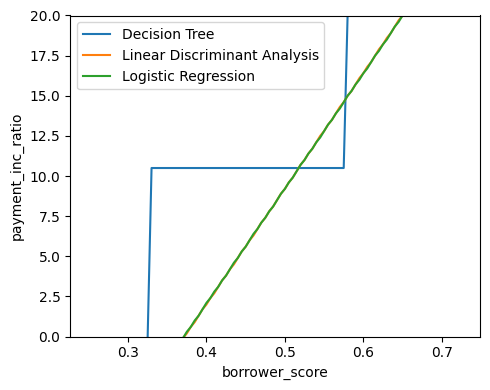

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
boundaries.plot(x='borrower_score', ax=ax)
ax.set_ylabel('payment_inc_ratio')
ax.set_ylim(0, 20)

plt.tight_layout()
plt.show()

## Future Sales Prediction with Machine Learning
### Author AMAN KHARWAL


Predicting the future sales of a product helps a business manage the manufacturing and advertising cost of the product. So if you want to learn to predict the future sales of a product with machine learning, this article is for you. In this article, I will take you through the _task of future sales prediction_ with machine learing using __Python__.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/amankharwal/Website-data/master/advertising.csv")
data.head()

TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3   12.0
3  151.5   41.3       58.5   16.5
4  180.8   10.8       58.4   17.9

In [ ]:
data.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

So this dataset doesn't have any null values. Now let's visualize the relationship between the amount spent on advertising on TV and units sold:

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

figure = px.scatter(data_frame=data, x="Sales", y="TV", size="TV", trendline="ols")

figure.show()

Now let's visualize the relationship between the amount spent on advertising on newspapers and units sold:

In [ ]:
figure = px.scatter(
    data_frame=data,
    x="Sales",
    y="Newspaper",
    size="Newspaper",
    trendline="ols"
)

figure.show()

Now let's visualise the relationship between the amount spent on advertising on radio and units sold:

In [ ]:
figure = px.scatter(
    data_frame = data,
    x = "Sales",
    y = "Radio",
    size = "Radio",
    trendline = "ols"
)

figure.show()

Out of all the amount spent on advertising on various platforms, I can see that the amount spent on advertising the product on TV results in more sales of the product. Now let's have a look at the correlation of all the columns with the sales column:

In [ ]:
correlation = data.corr()
correlation

TV     Radio  Newspaper     Sales
TV         1.000000  0.054809   0.056648  0.901208
Radio      0.054809  1.000000   0.354104  0.349631
Newspaper  0.056648  0.354104   1.000000  0.157960
Sales      0.901208  0.349631   0.157960  1.000000

In [ ]:
correlation['Sales'].sort_values(ascending=False)

Sales        1.000000
TV           0.901208
Radio        0.349631
Newspaper    0.157960
Name: Sales, dtype: float64

In [ ]:
X = data.drop(['Sales'], axis=1)
X

TV  Radio  Newspaper
0    230.1   37.8       69.2
1     44.5   39.3       45.1
2     17.2   45.9       69.3
3    151.5   41.3       58.5
4    180.8   10.8       58.4
..     ...    ...        ...
195   38.2    3.7       13.8
196   94.2    4.9        8.1
197  177.0    9.3        6.4
198  283.6   42.0       66.2
199  232.1    8.6        8.7

[200 rows x 3 columns]

In [ ]:
X = X.values
y = data['Sales'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now let's train the model to predict future sales

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9059011844150826

Now let's input values into the model according to the features we have used to train it and predict how many units of the product can be sold based on the amount spent on its advertising on various platforms:

In [ ]:
# features = [[TV, Radio, Newspaper]]
features = np.array([[230.1, 37.8, 69.2]])
model.predict(features)

array([21.37254028])

In [ ]:
!pip install dash --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 28.3 MB/s eta 0:00:00


## Building an End-to-End Machine Learning Model: Process We Can Follow

To build an End-to-End __Machine Learning__ Model is a comprehensive system that contains all the stages of a machine learning project, from data collection and preprocessing to model development, deployment, and ongoing maintenance. If you want to learn how to build an end-to-end Machine Learning Model, this article is for you. In this article, I'll take you through how to build an end-to-end Machine Learning model using Python and Dash

### Building an End-to-End Machine Learning Model: Process We Can Follow

To build an end-to-end Machine Learning model, you first need to train a Machine Learning model as you do in every Learning problem you solve. Once you have trained your model, below is the process you can follow to turn your Machine Learning model into an end-to-end solution using the dash framework:

1. Set up a new Dash application
2. Create the layout of the app using Dash's HTML and Core Components. It includes input fields, buttons, and output display areas.
3. Write callback functions to define the interactivity of the app, such as taking user inputs, running the model prediction, and displaying the results.
4. Load the model within the app to use for predictions

In [ ]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
real_estate_data = pd.read_csv("https://statso.io/wp-content/uploads/2023/12/Real_Estate.csv")

real_estate_data.head()

Transaction date  House age  Distance to the nearest MRT station  \
0  2012-09-02 16:42:30.519336       13.3                            4082.0150   
1  2012-09-04 22:52:29.919544       35.5                             274.0144   
2  2012-09-05 01:10:52.349449        1.1                            1978.6710   
3  2012-09-05 13:26:01.189083       22.2                            1055.0670   
4  2012-09-06 08:29:47.910523        8.5                             967.4000   

   Number of convenience stores   Latitude   Longitude  \
0                             8  25.007059  121.561694   
1                             2  25.012148  121.546990   
2                            10  25.003850  121.528336   
3                             5  24.962887  121.482178   
4                             6  25.011037  121.479946   

   House price of unit area  
0                  6.488673  
1                 24.970725  
2                 26.694267  
3                 38.091638  
4                 21.654710

In [ ]:
# Selecting features and target variable
features = ['Distance to the nearest MRT station', 'Number of convenience stores', 'Latitude', 'Longitude']
target = 'House price of unit area'

X = real_estate_data[features]
y = real_estate_data[target]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initialisation & training
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

Now, here's how we can create an end-to-end solution for our Machine Learning model by using the dash framework:

In [ ]:
__name__

'__main__'

In [ ]:
import dash
from dash import html, dcc, Input, Output, State
import pandas as pd

# Initialise the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.Div([
        html.H1("Real Estate Price Prediction", style={"text-align": "center"}),

        html.Div([
            dcc.Input(
                id="distance_to_mrt",
                type="number",
                placeholder="Distance to MRT Station (meters)",
                style={"margin": '10px', 'padding': '10px'}
            ),

            dcc.Input(
                id="num_convenience_stores",
                type="number",
                placeholder="Number of Convenience Stores",
                style={"margin": '10px', 'padding': '10px'}
            ),

            dcc.Input(
                id="latitude",
                type="number",
                placeholder="Latitude",
                style={"margin": '10px', 'padding': '10px'}
            ),

            dcc.Input(
                id="longitude",
                type="number",
                placeholder="Longitude",
                style={"margin": '10px', 'padding': '10px'}
            ),

            html.Button(
                "Predict Price",
                id="predict_button",
                n_clicks=0,
                style={"margin": '10px', 'padding': '10px', 'background-color': '#007BFF', 'color': 'white'}
            )
        ], style={'text-align': 'center'}),

        html.Div(
            id="prediction_output",
            style={"text-align": 'center', 'font-size': '20px', 'margin-top': '20px'}
        )
    ], style={'width': '50%', 'margin': '0 auto', 'border': '2px solid #007BFF', 'padding': '20px', 'border-radius': '10px'})
])


# Define callback to update output
@app.callback(
    Output("prediction_output", "children"),
    [Input('prediction_button', 'n_clicks')],
    [State('distance_to_mrt', 'value'),
     State('num_convenience_stores', 'value'),
     State('latitude', 'value'),
     State('longitude', 'value')]
)


def update_output(n_clicks, distance_to_mrt, num_convenience_stores, latitude, longitude):
  if n_clicks > 0 and all(v is not None for v in [distance_to_mrt, num_convenience_stores, latitude, longitude]):
    # Prepare the feature vector
    features = pd.DataFrame([[distance_to_mrt, num_convenience_stores, latitude, longitude]],
                            columns=['distance_to_mrt', 'num_convenience_stores', 'latitude', 'longitude'])

    # Predict
    prediction = model.predict(features)[0]

    return f'Predicted House Price of Unit Area: {prediction:.2f}'
  elif n_clicks > 0:
    return 'Please enter all values to get a prediction'
  return ''

# Run the app
if __name__ == '__main__':
  app.run_server(debug=True)

<IPython.core.display.Javascript object>

In [ ]:
import dash
from dash import html, dcc, Input, Output, State
import pandas as pd

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.Div([
        html.H1("Real Estate Price Prediction", style={'text-align': 'center'}),

        html.Div([
            dcc.Input(id='distance_to_mrt', type='number', placeholder='Distance to MRT Station (meters)',
                      style={'margin': '10px', 'padding': '10px'}),
            dcc.Input(id='num_convenience_stores', type='number', placeholder='Number of Convenience Stores',
                      style={'margin': '10px', 'padding': '10px'}),
            dcc.Input(id='latitude', type='number', placeholder='Latitude',
                      style={'margin': '10px', 'padding': '10px'}),
            dcc.Input(id='longitude', type='number', placeholder='Longitude',
                      style={'margin': '10px', 'padding': '10px'}),
            html.Button('Predict Price', id='predict_button', n_clicks=0,
                        style={'margin': '10px', 'padding': '10px', 'background-color': '#007BFF', 'color': 'white'}),
        ], style={'text-align': 'center'}),

        html.Div(id='prediction_output', style={'text-align': 'center', 'font-size': '20px', 'margin-top': '20px'})
    ], style={'width': '50%', 'margin': '0 auto', 'border': '2px solid #007BFF', 'padding': '20px', 'border-radius': '10px'})
])

# Define callback to update output
@app.callback(
    Output('prediction_output', 'children'),
    [Input('predict_button', 'n_clicks')],
    [State('distance_to_mrt', 'value'),
     State('num_convenience_stores', 'value'),
     State('latitude', 'value'),
     State('longitude', 'value')]
)
def update_output(n_clicks, distance_to_mrt, num_convenience_stores, latitude, longitude):
    if n_clicks > 0 and all(v is not None for v in [distance_to_mrt, num_convenience_stores, latitude, longitude]):
        # Prepare the feature vector
        features = pd.DataFrame([[distance_to_mrt, num_convenience_stores, latitude, longitude]],
                                columns=['distance_to_mrt', 'num_convenience_stores', 'latitude', 'longitude'])
        # Predict
        prediction = model.predict(features)[0]
        return f'Predicted House Price of Unit Area: {prediction:.2f}'
    elif n_clicks > 0:
        return 'Please enter all values to get a prediction'
    return ''

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

In [ ]:
import random

n = random.randrange(1, 10)
guess = int(input('Enter any number: '))
while n != guess:
  if guess < n:
    print("Too low")
    guess = int(input("Enter number again: "))
  elif guess > n:
    print("Too high")
    guess = int(input("Enter number again: "))
  else:
    break
print("You guessed it right!")

Enter any number: 7
Too high
Enter number again: 5
You guessed it right!


In [ ]:
[random.randrange(1, 10) for _ in range(20)]

[8, 4, 3, 7, 1, 5, 7, 8, 8, 8, 4, 6, 6, 2, 5, 6, 9, 1, 6, 9]

In [ ]:
random.randrange(1, 10)

4

In [ ]:
random.randrange(1, 10)

2

In [ ]:
# Mean
list1 = [12, 16, 20, 20, 12, 30, 25, 23, 24, 20]
mean = sum(list1)/len(list1)
print(mean)

20.2


In [ ]:
# Median
list1 = [12, 16, 20, 20, 12, 30, 25, 23, 24, 20]
list1.sort()
list1

[12, 12, 16, 20, 20, 20, 23, 24, 25, 30]

In [ ]:
if len(list1) % 2 == 0:
  m1 = list1[len(list1)//2]
  m2 = list1[len(list1)//2 - 1]
  median = (m1 + m2) / 2
else:
  median = list1[len(list1)//2]

print(median)

20.0


In [ ]:
# Mode
list1 = [12, 16, 20, 20, 12, 30, 25, 23, 24, 20]
frequency = {}
for i in list1:
  frequency.setdefault(i, 0)
  frequency[i] += 1

frequency

{12: 2, 16: 1, 20: 3, 30: 1, 25: 1, 23: 1, 24: 1}

In [ ]:
frequent = max(frequency.values())
for i, j in frequency.items():
  if j == frequent:
    mode = i
print(mode)

20


In [ ]:
import getpass

database = {"aman.kharwal": "123456", "kharwal.aman": "654321"}
username = input("Enter your username: ")
password = getpass.getpass("Enter your password: ")

for i in database.keys():
  if username == i:
    while password != database.get(i):
      password = getpass.getpass("Enter your password again: ")
    break

print("Verified")

Enter your username: aman.kharwal
Enter your password: ··········
Verified


In [ ]:
!python3 --version

Python 3.10.12


## Dynamic Pricing Strategy using Python

Dynamic Pricing is an application of data science that involves adjusting the prices of a product or service based on various factors in real time. It is used by companies to optimize revenue by setting flexible prices that respond to market demand, demographics, customer behaviour and competitor prices. So, if you want to learn how to build a data-driven Dynamic Pricing Strategy, this article is for you.

Dynamic Pricing is an application of Data Science that involves adjusting product or service prices based on various factors in real time. It is employed by businesses to optimise their revenue and profitability by setting flexible prices that respond to market demand, customer behaviour, and competitor pricing.

For example, consider a ride-sharing company operating in a metropolitan area. The company wants to optimise its pricing strategy to maximise revenue and improve customer satisfaction. The traditional pricing model used by the business is based on fixed rates per kilometre, which does not account for fluctuations in a supply and demand.

So, in a dynamic pricing strategy, the aim is to maximise revenue and profitability by pricing items at the right level that balances supply and demand dynamics. It allows businesses to adjust prices dynamically based on factors like time of day, day of the week, customer segments, inventory levels, seasonal fluctuations, competitor pricing, and market conditions.

To implement a data-driven dynamic pricing strategy, businesses typically require data that can provide insights into customer behaviour, market trends, and other influencing factors. So to create a dynamic pricing strategy, we need to have a dataset based on:

1. historical sales data
2. customer purchase patterns
3. market demand forecasts
4. cost data
5. customer segmentation data
6. and real-time market data

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


data = pd.read_csv("https://statso.io/wp-content/uploads/2023/06/dynamic_pricing.csv")
data.head()

Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium                      90   
1         Evening      Economy                      43   
2       Afternoon      Premium                      76   
3       Afternoon      Premium                     134   
4       Afternoon      Economy                     149   

   Historical_Cost_of_Ride  
0               284.257273  
1               173.874753  
2               329.795469  
3               470.201232  
4               579.681422

In [ ]:
data.describe()

Number_of_Riders  Number_of_Drivers  Number_of_Past_Rides  \
count       1000.000000        1000.000000           1000.000000   
mean          60.372000          27.076000             50.031000   
std           23.701506          19.068346             29.313774   
min           20.000000           5.000000              0.000000   
25%           40.000000          11.000000             25.000000   
50%           60.000000          22.000000             51.000000   
75%           81.000000          38.000000             75.000000   
max          100.000000          89.000000            100.000000   

       Average_Ratings  Expected_Ride_Duration  Historical_Cost_of_Ride  
count      1000.000000              1000.00000              1000.000000  
mean          4.257220                99.58800               372.502623  
std           0.435781                49.16545               187.158756  
min           3.500000                10.00000                25.993449  
25%           3.870000                59.75000               221.365202  
50%           4.270000               102.00000               362.019426  
75%           4.632500               143.00000               510.497504  
max           5.000000               180.00000               836.116419

Now let's have a look at the relationship between expected ride duration and the historical cost of the ride.

In [ ]:
fig = px.scatter(
    data,
    x='Expected_Ride_Duration',
    y='Historical_Cost_of_Ride',
    title='Expected Ride Duration vs. Historical Cost of Ride',
    trendline='ols'
)

fig.show()

Now let's have a look at the distribution of the historical cost of rides based on the vehicle type:

In [ ]:
data['Vehicle_Type'].value_counts()

Vehicle_Type
Premium    522
Economy    478
Name: count, dtype: int64

In [ ]:
data['Historical_Cost_of_Ride'].dtype

dtype('float64')

In [ ]:
fig = px.box(data,
             x='Vehicle_Type',
             y='Historical_Cost_of_Ride',
             title='Historical Cost of Ride Distribution by Vehicle Type')

fig.show()

In [ ]:
corr_matrix = data.corr(numeric_only=True)
corr_matrix

Number_of_Riders  Number_of_Drivers  \
Number_of_Riders                 1.000000           0.627016   
Number_of_Drivers                0.627016           1.000000   
Number_of_Past_Rides             0.029265           0.039660   
Average_Ratings                  0.008572           0.041204   
Expected_Ride_Duration          -0.015856          -0.024418   
Historical_Cost_of_Ride          0.005826           0.017082   

                         Number_of_Past_Rides  Average_Ratings  \
Number_of_Riders                     0.029265         0.008572   
Number_of_Drivers                    0.039660         0.041204   
Number_of_Past_Rides                 1.000000        -0.064734   
Average_Ratings                     -0.064734         1.000000   
Expected_Ride_Duration               0.030679        -0.016968   
Historical_Cost_of_Ride              0.035859        -0.001063   

                         Expected_Ride_Duration  Historical_Cost_of_Ride  
Number_of_Riders                      -0.015856                 0.005826  
Number_of_Drivers                     -0.024418                 0.017082  
Number_of_Past_Rides                   0.030679                 0.035859  
Average_Ratings                       -0.016968                -0.001063  
Expected_Ride_Duration                 1.000000                 0.927547  
Historical_Cost_of_Ride                0.927547                 1.000000

In [ ]:
go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='Viridis'
)

Heatmap({
    'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                   [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                   '#31688e'], [0.4444444444444444, '#26828e'],
                   [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                   '#35b779'], [0.7777777777777778, '#6ece58'],
                   [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
    'x': array(['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides',
                'Average_Ratings', 'Expected_Ride_Duration', 'Historical_Cost_of_Ride'],
               dtype=object),
    'y': array(['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides',
                'Average_Ratings', 'Expected_Ride_Duration', 'Historical_Cost_of_Ride'],
               dtype=object),
    'z': array([[ 1.        ,  0.62701634,  0.02926507,  0.00857155, -0.01585625,
                  0.0058257 ],
                [ 0.62701634,  1.        ,  0.03966045,  0.041

In [ ]:
fig = go.Figure(
    data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale='Viridis'
    )
)

fig.update_layout(
    title='Correlation Matrix'
)

fig.show()

In [ ]:
a = np.arange(10)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
np.where(a < 5, a, 10*a)

array([ 0,  1,  2,  3,  4, 50, 60, 70, 80, 90])

In [ ]:
import numpy as np

# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

data['demand_multiplier'] = np.where(data['Number_of_Riders'] > np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], low_demand_percentile))


# Calculate supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

data['supply_multiplier'] = np.where(data['Number_of_Drivers'] > np.percentile(data['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(data['Number_of_Drivers'], high_supply_percentile) / data['Number_of_Drivers'],
                                     np.percentile(data['Number_of_Drivers'], low_supply_percentile) / data['Number_of_Drivers'])



data.head()

Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium                      90   
1         Evening      Economy                      43   
2       Afternoon      Premium                      76   
3       Afternoon      Premium                     134   
4       Afternoon      Economy                     149   

   Historical_Cost_of_Ride  demand_multiplier  supply_multiplier  
0               284.257273           1.111111           0.844444  
1               173.874753           1.450000           0.974359  
2               329.795469           1.050000           1.225806  
3               470.201232           1.098765           1.357143  
4               579.681422           1.950000           1.727273

In [ ]:
# Define price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2  # Higher demand threshold
demand_threshold_low = 0.8   # Lower demand threshold
supply_threshold_high = 0.8  # Higher supply threshold
supply_threshold_low  = 1.2  # Lower supply threshold

# Calculate adjusted_ride_cost for dynamic pricing
data['adjusted_ride_cost'] = data['Historical_Cost_of_Ride'] * (
    np.maximum(data['demand_multiplier'], demand_threshold_low) *
    np.maximum(data['supply_multiplier'], supply_threshold_high)
)

In [ ]:
np.maximum(data['demand_multiplier'], demand_threshold_low)

0      1.111111
1      1.450000
2      1.050000
3      1.098765
4      1.950000
         ...   
995    0.825000
996    1.037037
997    1.100000
998    1.325000
999    1.950000
Name: demand_multiplier, Length: 1000, dtype: float64

In [ ]:
np.maximum(data['supply_multiplier'], supply_threshold_high)

0      0.844444
1      0.974359
2      1.225806
3      1.357143
4      1.727273
         ...   
995    1.652174
996    1.310345
997    1.833333
998    1.407407
999    0.800000
Name: supply_multiplier, Length: 1000, dtype: float64

In [ ]:
data.head()

Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium                      90   
1         Evening      Economy                      43   
2       Afternoon      Premium                      76   
3       Afternoon      Premium                     134   
4       Afternoon      Economy                     149   

   Historical_Cost_of_Ride  demand_multiplier  supply_multiplier  \
0               284.257273           1.111111           0.844444   
1               173.874753           1.450000           0.974359   
2               329.795469           1.050000           1.225806   
3               470.201232           1.098765           1.357143   
4               579.681422           1.950000           1.727273   

   adjusted_ride_cost  
0          266.710528  
1          245.653817  
2          424.478684  
3          701.155452  
4         1952.472427

In [ ]:
# Calculate the profit percentage for each ride
data['profit_percentage'] = ((data['adjusted_ride_cost'] - data['Historical_Cost_of_Ride']) / data['Historical_Cost_of_Ride'])

# Identify profitable rides where profit percentage is positive
profitable_rides = data[data['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = data[data['profit_percentage'] < 0]

import plotly.graph_objects as go

# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a dognut chart to show the distribution of profitable rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

fig = go.Figure(
    data=[go.Pie(labels=labels, values=values, hole=0.4)]
)

fig.update_layout(
    title='Profitability of Rides (Dynamic Pricing vs. Historical Pricing)'
)

fig.show()

Now let's have a look at the relationship between the expected ride duration and the cost of the ride based on the dynamic pricing strategy:

In [ ]:
fig = px.scatter(data,
                 x='Expected_Ride_Duration',
                 y='adjusted_ride_cost',
                 title='Expected Ride Duration vs. Adjusted Ride Cost',
                 trendline='ols')

fig.show()

## Training a Predictive Model

Now, as we have implemented a dynamic pricing strategy, let's train a Machine Learning Model. Before training the model, let's preprocess the data:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def data_preprocessing_pipeline(data):
  # Identify numeric and categorical features
  numeric_features = data.select_dtypes(include=['float', 'int']).columns
  categorical_features = data.select_dtypes(include=['object']).columns

  # Handle missing values in numeric features
  data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

  # Detect and handle outliers in numeric eatures using IQR
  for feature in numeric_features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[feature] = np.where((data[feature] < lower_bound) | (data[feature] > upper_bound),
                             data[feature].mean(),
                             data[feature])

  # Handle missing values in categorical features
  data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])

  return data

In [ ]:
data['Vehicle_Type'].head()

0    Premium
1    Economy
2    Premium
3    Premium
4    Economy
Name: Vehicle_Type, dtype: object

In [ ]:
data['Vehicle_Type'] = data['Vehicle_Type'].map({'Premium': 1, 'Economy':0})
data['Vehicle_Type'].head()

0    1
1    0
2    1
3    1
4    0
Name: Vehicle_Type, dtype: int64

In [ ]:
## Splitting the data
from sklearn.model_selection import train_test_split

X = np.array(data[["Number_of_Riders", "Number_of_Drivers", "Vehicle_Type", "Expected_Ride_Duration"]])
y = np.array(data[['adjusted_ride_cost']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.shape, y.shape

((1000, 4), (1000, 1))

In [ ]:
# Reshape y to 1D array
y_train = y_train.ravel()
y_test = y_test.ravel()

In [ ]:
y_train.shape

(800,)

In [ ]:
y_test.shape

(200,)

In [ ]:
# Training a random forest regression model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
def get_vehicle_type_numeric(vehicle_type):
  vehicle_type_mapping = {
      'Premium': 1,
      'Economy': 0
  }
  vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
  return vehicle_type_numeric

In [ ]:
get_vehicle_type_numeric('Premium')

1

In [ ]:
get_vehicle_type_numeric('Economy')

0

In [ ]:
get_vehicle_type_numeric('Sale')

In [ ]:
## Predicting using user input values
def predict_price(number_of_riders, number_of_drivers, vehicle_type, expected_ride_duration):
  vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
  if vehicle_type_numeric is None:
    raise ValueError("Invalid vehicle type")

  input_data = np.array([[number_of_riders, number_of_drivers, vehicle_type_numeric, expected_ride_duration]])
  predicted_price = model.predict(input_data)
  return predicted_price


In [ ]:
# Example prediction using user_input values
user_number_of_riders = 50
user_number_of_drivers = 25
user_vehicle_type = 'Economy'
expected_ride_duration = 30
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, user_vehicle_type, expected_ride_duration)
print(f"Predicted Price: {predicted_price}")

Predicted Price: [255.910814]


In [ ]:
import plotly.graph_objects as go

# Predict on the test set
y_pred = model.predict(X_test)

# Create a scatter plot with actual vs predicted values
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=y_test.flatten(),
        y=y_pred,
        mode='markers',
        name='Actual vs Predicted'
    )
)


# Add a line representing the idea case
fig.add_trace(
    go.Scatter(
        x=[min(y_test.flatten()), max(y_test.flatten())],
        y=[min(y_test.flatten()), max(y_test.flatten())],
        mode='lines',
        name='Ideal',
        line=dict(color='red', dash='dash')
    )
)

fig.update_layout(
    title='Actual vs Predicted Values',
    xaxis_title='Actual Values',
    yaxis_title='Predicted Values',
    showlegend=True
)

fig.show()

In a dynamic pricing strategy, the aim is to maximise revenue and profitability by pricing items at the right level that balances supply and demand dynamics. It allows businesses to adjust prices dynamically based on factors like _time of day_, _day of the week_, _customer segments_, _inventory levels_, _seasonal fluctuations_, _competitor pricing_, and _market conditions_.

## Music Popularity Prediction with Python

__Music popularity prediction__ involves developing *machine learning* models to estimate the popularity of music tracks based on their audio features. Predicting the popularity of music can help music streaming platforms understand user preferences, optimise playlists and enhance *recommendation systems* to improve user engagement and satisfaction. In this article, we learn how to build a music popularity prediction system.

Music popularity prediction means using _regression techniques to forecast the popularity of songs based on various music features and metadata._ Expected results include accurate predictions of a song's future performance in terms of streams, downloads and chart positions, which enable music producers, artists, and marketers to make informed decisions.

In [ ]:
import pandas as pd

spotify_data = pd.read_csv("https://statso.io/wp-content/uploads/2024/07/Spotify_data.csv")

spotify_data.head()

Unnamed: 0                  Track Name  \
0           0                 Not Like Us   
1           1                     Houdini   
2           2  BAND4BAND (feat. Lil Baby)   
3           3          I Don't Wanna Wait   
4           4                       Pedro   

                                   Artists                  Album Name  \
0                           Kendrick Lamar                 Not Like Us   
1                                   Eminem                     Houdini   
2                    Central Cee, Lil Baby  BAND4BAND (feat. Lil Baby)   
3                David Guetta, OneRepublic          I Don't Wanna Wait   
4  Jaxomy, Agatino Romero, Raffaella Carrà                       Pedro   

                 Album ID                Track ID  Popularity Release Date  \
0  5JjnoGJyOxfSZUZtk2rRwZ  6AI3ezQ4o3HUoP6Dhudph3          96   2024-05-04   
1  6Xuu2z00jxRPZei4IJ9neK  2HYFX63wP3otVIvopRS99Z          94   2024-05-31   
2  4AzPr5SUpNF553eC1d3aRy  7iabz12vAuVQYyekFIWJxD          91   2024-05-23   
3  0wCLHkBRKcndhMQQpeo8Ji  331l3xABO0HMr1Kkyh2LZq          90   2024-04-05   
4  5y6RXjI5VPR0RyInghTbf1  48lxT5qJF0yYyf2z4wB4xW          89   2024-03-29   

   Duration (ms)  Explicit  ... Energy  Key  Loudness  Mode  Speechiness  \
0         274192      True  ...  0.472    1    -7.001     1       0.0776   
1         227239      True  ...  0.887    9    -2.760     0       0.0683   
2         140733      True  ...  0.764   11    -5.241     1       0.2040   
3         149668     False  ...  0.714    1    -4.617     0       0.0309   
4         144846     False  ...  0.936    9    -6.294     1       0.3010   

   Acousticness  Instrumentalness  Liveness  Valence    Tempo  
0        0.0107          0.000000    0.1410    0.214  101.061  
1        0.0292          0.000002    0.0582    0.889  127.003  
2        0.3590          0.000000    0.1190    0.886  140.113  
3        0.0375          0.000000    0.2320    0.554  129.976  
4        0.0229          0.000001    0.3110    0.844  151.019  

[5 rows x 22 columns]

In [ ]:
spotify_data.columns

Index(['Unnamed: 0', 'Track Name', 'Artists', 'Album Name', 'Album ID',
       'Track ID', 'Popularity', 'Release Date', 'Duration (ms)', 'Explicit',
       'External URLs', 'Danceability', 'Energy', 'Key', 'Loudness', 'Mode',
       'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo'],
      dtype='object')

In [ ]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        227 non-null    int64  
 1   Track Name        227 non-null    object 
 2   Artists           227 non-null    object 
 3   Album Name        227 non-null    object 
 4   Album ID          227 non-null    object 
 5   Track ID          227 non-null    object 
 6   Popularity        227 non-null    int64  
 7   Release Date      227 non-null    object 
 8   Duration (ms)     227 non-null    int64  
 9   Explicit          227 non-null    bool   
 10  External URLs     227 non-null    object 
 11  Danceability      227 non-null    float64
 12  Energy            227 non-null    float64
 13  Key               227 non-null    int64  
 14  Loudness          227 non-null    float64
 15  Mode              227 non-null    int64  
 16  Speechiness       227 non-null    float64
 1

In [ ]:
spotify_data.drop(columns=['Unnamed: 0'], inplace=True)

spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track Name        227 non-null    object 
 1   Artists           227 non-null    object 
 2   Album Name        227 non-null    object 
 3   Album ID          227 non-null    object 
 4   Track ID          227 non-null    object 
 5   Popularity        227 non-null    int64  
 6   Release Date      227 non-null    object 
 7   Duration (ms)     227 non-null    int64  
 8   Explicit          227 non-null    bool   
 9   External URLs     227 non-null    object 
 10  Danceability      227 non-null    float64
 11  Energy            227 non-null    float64
 12  Key               227 non-null    int64  
 13  Loudness          227 non-null    float64
 14  Mode              227 non-null    int64  
 15  Speechiness       227 non-null    float64
 16  Acousticness      227 non-null    float64
 1

In [ ]:
spotify_data.head()

Track Name                                  Artists  \
0                 Not Like Us                           Kendrick Lamar   
1                     Houdini                                   Eminem   
2  BAND4BAND (feat. Lil Baby)                    Central Cee, Lil Baby   
3          I Don't Wanna Wait                David Guetta, OneRepublic   
4                       Pedro  Jaxomy, Agatino Romero, Raffaella Carrà   

                   Album Name                Album ID                Track ID  \
0                 Not Like Us  5JjnoGJyOxfSZUZtk2rRwZ  6AI3ezQ4o3HUoP6Dhudph3   
1                     Houdini  6Xuu2z00jxRPZei4IJ9neK  2HYFX63wP3otVIvopRS99Z   
2  BAND4BAND (feat. Lil Baby)  4AzPr5SUpNF553eC1d3aRy  7iabz12vAuVQYyekFIWJxD   
3          I Don't Wanna Wait  0wCLHkBRKcndhMQQpeo8Ji  331l3xABO0HMr1Kkyh2LZq   
4                       Pedro  5y6RXjI5VPR0RyInghTbf1  48lxT5qJF0yYyf2z4wB4xW   

   Popularity Release Date  Duration (ms)  Explicit  \
0          96   2024-05-04         274192      True   
1          94   2024-05-31         227239      True   
2          91   2024-05-23         140733      True   
3          90   2024-04-05         149668     False   
4          89   2024-03-29         144846     False   

                                       External URLs  ...  Energy  Key  \
0  https://open.spotify.com/track/6AI3ezQ4o3HUoP6...  ...   0.472    1   
1  https://open.spotify.com/track/2HYFX63wP3otVIv...  ...   0.887    9   
2  https://open.spotify.com/track/7iabz12vAuVQYye...  ...   0.764   11   
3  https://open.spotify.com/track/331l3xABO0HMr1K...  ...   0.714    1   
4  https://open.spotify.com/track/48lxT5qJF0yYyf2...  ...   0.936    9   

   Loudness  Mode  Speechiness  Acousticness  Instrumentalness  Liveness  \
0    -7.001     1       0.0776        0.0107          0.000000    0.1410   
1    -2.760     0       0.0683        0.0292          0.000002    0.0582   
2    -5.241     1       0.2040        0.3590          0.000000    0.1190   
3    -4.617     0       0.0309        0.0375          0.000000    0.2320   
4    -6.294     1       0.3010        0.0229          0.000001    0.3110   

   Valence    Tempo  
0    0.214  101.061  
1    0.889  127.003  
2    0.886  140.113  
3    0.554  129.976  
4    0.844  151.019  

[5 rows x 21 columns]

Now, let's get started with EDA. As popularity is the target variable, I'll have a look at the relationship between all the music features with popularity.

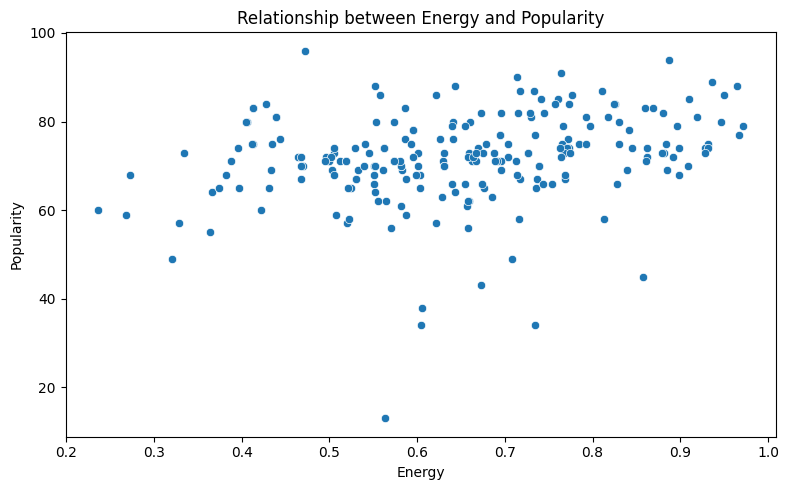

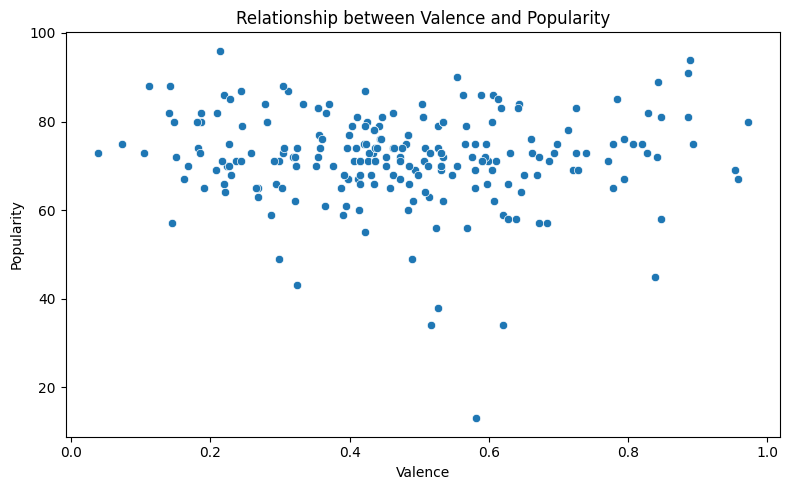

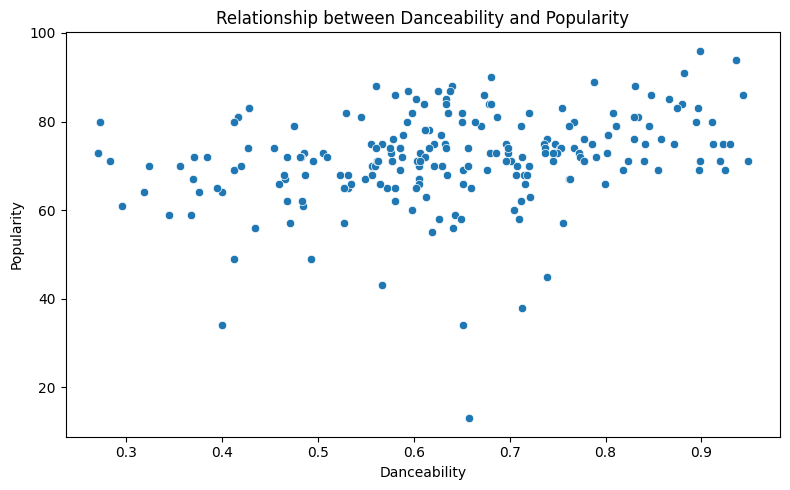

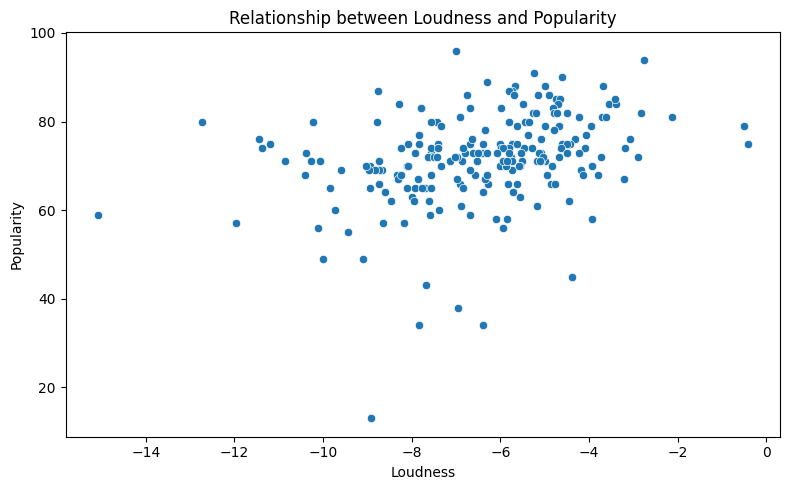

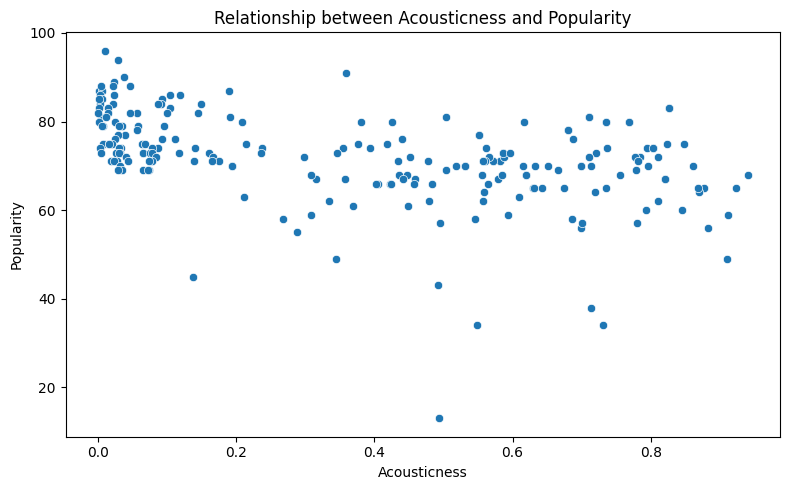

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['Energy', 'Valence', 'Danceability', 'Loudness', 'Acousticness']

for feature in features:
  plt.figure(figsize=(8, 5))
  sns.scatterplot(data=spotify_data, x=feature, y='Popularity')
  plt.title(f'Relationship between {feature} and Popularity')
  plt.tight_layout()
  plt.show()



In [ ]:
numeric_columns = spotify_data.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['Popularity', 'Duration (ms)', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo'],
      dtype='object')

In [ ]:
numeric_data = spotify_data[numeric_columns]
numeric_data.head()

Popularity  Duration (ms)  Danceability  Energy  Key  Loudness  Mode  \
0          96         274192         0.898   0.472    1    -7.001     1   
1          94         227239         0.936   0.887    9    -2.760     0   
2          91         140733         0.882   0.764   11    -5.241     1   
3          90         149668         0.681   0.714    1    -4.617     0   
4          89         144846         0.788   0.936    9    -6.294     1   

   Speechiness  Acousticness  Instrumentalness  Liveness  Valence    Tempo  
0       0.0776        0.0107          0.000000    0.1410    0.214  101.061  
1       0.0683        0.0292          0.000002    0.0582    0.889  127.003  
2       0.2040        0.3590          0.000000    0.1190    0.886  140.113  
3       0.0309        0.0375          0.000000    0.2320    0.554  129.976  
4       0.3010        0.0229          0.000001    0.3110    0.844  151.019

In [ ]:
corr_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
corr_matrix['Popularity'].sort_values(ascending=False)

Popularity          1.000000
Loudness            0.308110
Danceability        0.251928
Energy              0.250068
Speechiness         0.190621
Tempo               0.131820
Instrumentalness    0.104846
Liveness            0.066110
Mode               -0.008246
Key                -0.008550
Valence            -0.045580
Duration (ms)      -0.269510
Acousticness       -0.431117
Name: Popularity, dtype: float64

In [ ]:
corr_matrix['Duration (ms)'].sort_values(ascending=False)

Duration (ms)       1.000000
Acousticness        0.476488
Mode                0.158170
Key                -0.012312
Liveness           -0.104685
Tempo              -0.160446
Instrumentalness   -0.212550
Valence            -0.217561
Loudness           -0.256522
Popularity         -0.269510
Speechiness        -0.312642
Energy             -0.365698
Danceability       -0.484826
Name: Duration (ms), dtype: float64

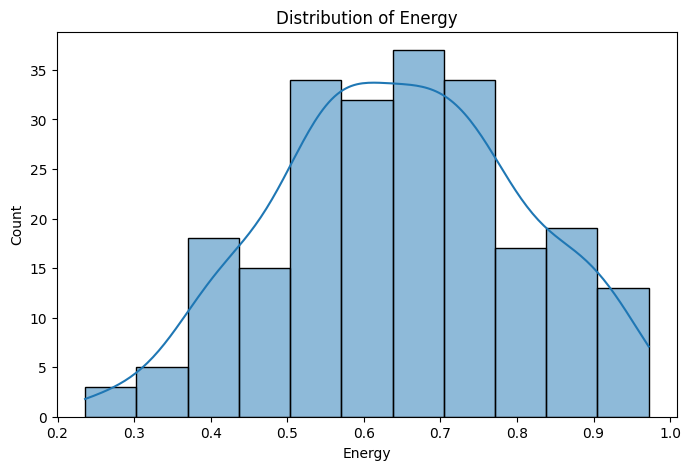

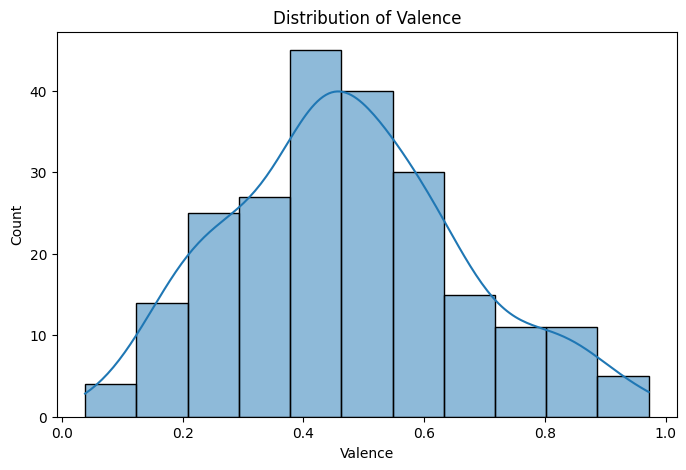

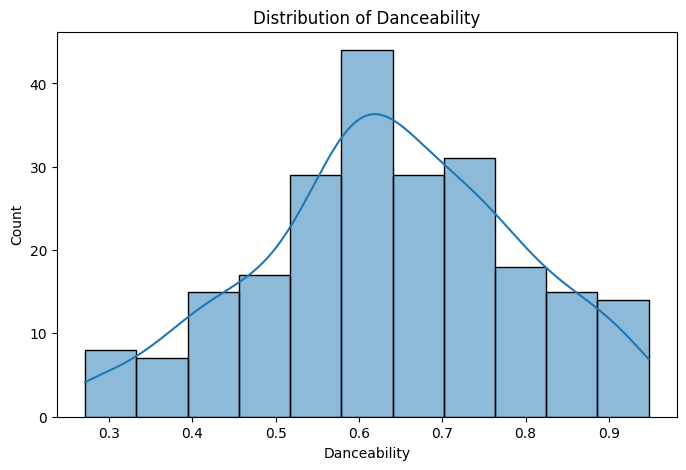

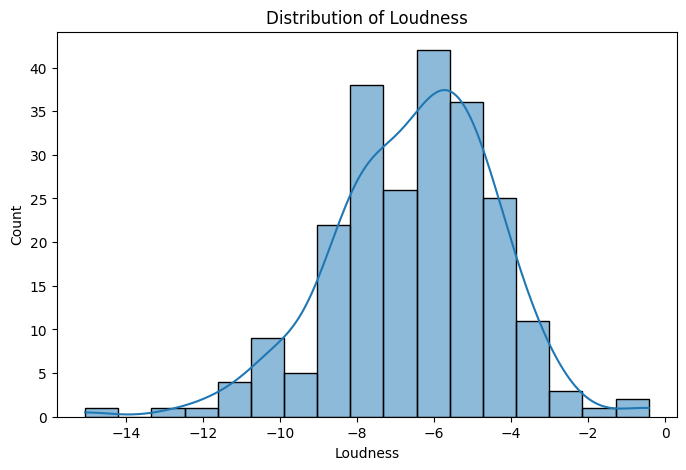

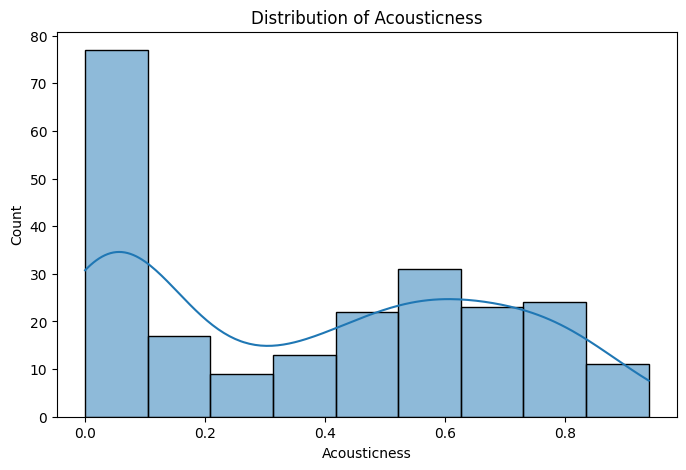

In [ ]:
for feature in features:
  plt.figure(figsize=(8, 5))
  sns.histplot(spotify_data[feature], kde=True)
  plt.title(f'Distribution of {feature}')
  plt.show()

## Feature Selection and Model Training

Based on the correlation analysis and visualizations, the following features show a significant relationship with popularity and can be used to train a music popularity prediction model:

* Energy
* Valence
* Danceability
* Loudness
* Acousticness
* Tempo
* Speechiness
* Liveness

These features capture various audio characteristics that influence the popularity of music tracks.


The next step is to train a Machine Learning model to predict the popularity of music using the features we have selected. So let's split and scale the data and then train the model using the random forest regression algorithm:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Select the features and target variable
features = ['Energy', 'Valence', 'Danceability', 'Loudness', 'Acousticness', 'Tempo', 'Speechiness', 'Liveness']

X = spotify_data[features]
y = spotify_data['Popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    refit=True,
    verbose=2,
    cv=5
)

grid_search_rf.fit(X_train_scaled, y_train)

best_params_rf = grid_search_rf.best_params_

best_rf_model = grid_search_rf.best_estimator_

y_pred_best_rf = best_rf_model.predict(X_test_scaled)

# Evaluate the model

NameError: name 'GridSearchCV' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Select the features and target variable
features = ['Energy', 'Valence', 'Danceability', 'Loudness', 'Acousticness', 'Tempo', 'Speechiness', 'Liveness']

X = spotify_data[features]
y = spotify_data['Popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    refit=True,
    verbose=2,
    cv=5
)

grid_search_rf.fit(X_train_scaled, y_train)

best_params_rf = grid_search_rf.best_params_

best_rf_model = grid_search_rf.best_estimator_

y_pred_best_rf = best_rf_model.predict(X_test_scaled)

# Evaluate the model

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, mi

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_features=sqrt, mi

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, mi

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraT

[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max

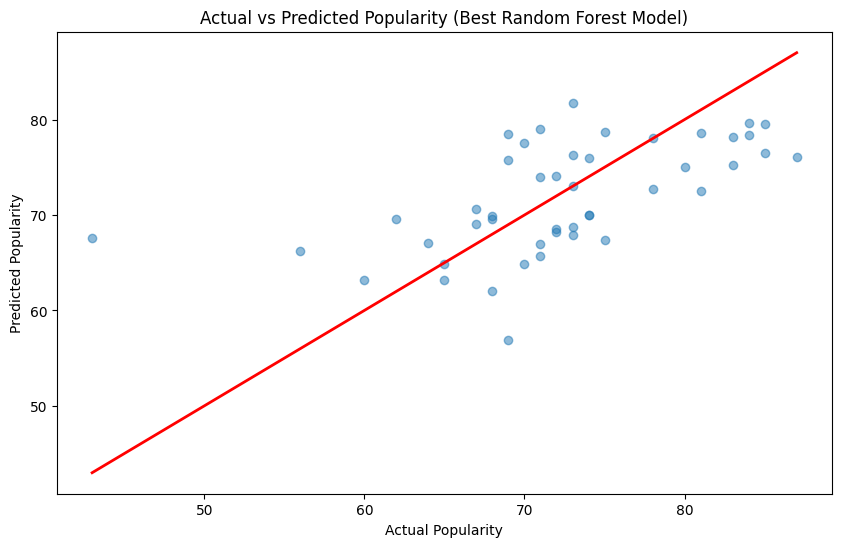

In [ ]:
# make predictions
y_pred_best_rf = best_rf_model.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_rf, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs Predicted Popularity (Best Random Forest Model)')
plt.show()

In [ ]:
value = input("Please enter a value: ")
print(value)

Please enter a value: 23
23


In [ ]:
import sys
import random

print("")
player_choice = input("Enter ...\n1 for Rock, \n2 for Paper, or \n3 for Scissors:\n\n")

player = int(player_choice)

if player < 1 | player > 3:
  sys.exit("You must enter 1, 2, or 3.")


computer_choice = random.choice("123")
computer = int(computer_choice)

print("")
print(f"You chose {player}.")
print(f"Computer chose {computer}.\n")

if player == 1 and computer == 3:
  print("You win!")
elif player == 2 and computer == 1:
  print("You win!")
elif player == 3 and computer == 2:
  print("You win!")
elif player == computer:
  print("It's a tie!")
else:
  print("Computer wins!")


Enter ...
1 for Rock, 
2 for Paper, or 
3 for Scissors:

2

You chose 2.
Computer chose 1.

You win!


Before we end this introduction, let us look at a simple example of a supervised machine learning model, the _K_-Nearest Neighbours (_K_-NN) model. It is a _non-parametric_ method used for classification and regression. In both cases, the input consists of the _K_ closest training examples in the feature space. The output depends on whether _K_-NN is used for classification or regression.

The ingredients of a _K_-NN model are the training data. The transparency of a _K_-NN model is the _distance between the test point and the training points_.

## Ingredients
* Input: features of data samples
* Output: class labels of data samples
* Model: assigned __dominant class label__ of the _K_-nearest neighbours (in training data) of a test sample to it
    - Hyperparameter(s): the number of nearest neighbours _K_
    - Parameters: nonparametric (i.e., no parameters to learn, only store the training data)
* Loss function: minimise distance between samples
* Learning algorithm: sorting distances between samples

## System transparency

### System logic
* Condition to produce certain output: to produce a sample with label _c_, find a data point in the input space where the majority of its nearest neighbours have label _c_.

## Example: iris classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)

print(neigh.predict([[1.1]]))

[0]


In [ ]:
neigh.predict_proba([[0.9]])

array([[0.66666667, 0.33333333]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

In [ ]:
iris = datasets.load_iris()

In [ ]:
type(iris)

sklearn.utils._bunch.Bunch

In [ ]:
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [ ]:
X = iris.data[:, :2]
X.shape

(150, 2)

In [ ]:
y = iris.target
y.shape

(150,)

Let us visualise the data samples in a 2D plot below using the _scatter_ function the _matplotlib.pyplot_ library. This is useful for getting intuition about the data. The colour of each data point corresponds to its label.

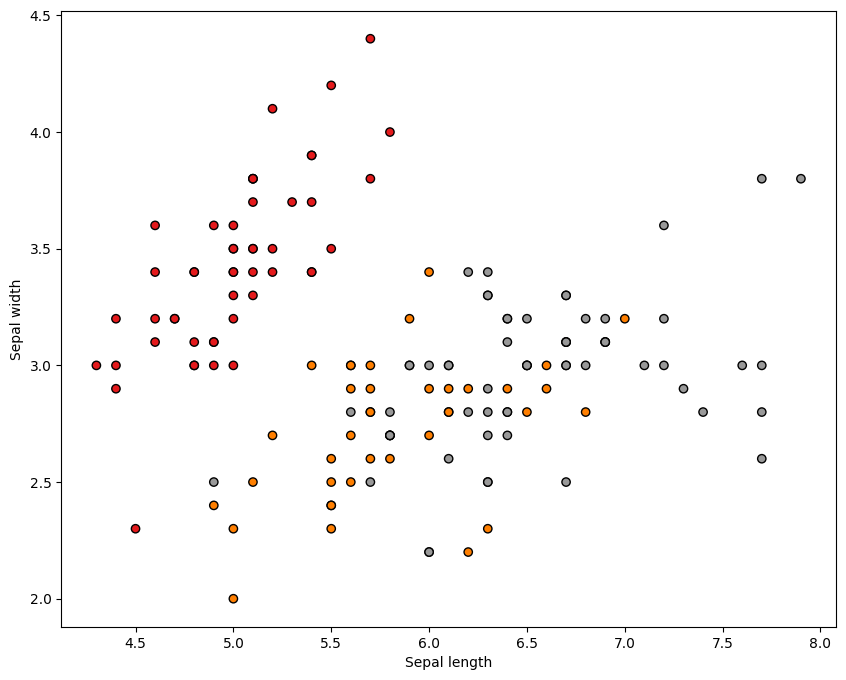

In [ ]:
plt.figure(figsize=(10, 8))

plt.scatter(
    iris.data[:, 0], iris.data[:, 1], c=iris.target, cmap=plt.cm.Set1, edgecolor='k'
)

plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

In [ ]:
h = 0.02 # step size in the mesh

# Create colour maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Plot the decision boundary. For that, we will assign a colour to each
# point in the mesh [x_min, x_max] x [y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

print(x_min, x_max, y_min, y_max)

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

3.3 8.9 1.0 5.4


In [ ]:
xx.shape

(220, 280)

In [ ]:
yy.shape

(220, 280)

In [ ]:
(8.9 - 3.3) / h,  (5.4 - 1.0) / h

(280.0, 220.0)

In [ ]:
len(np.arange(x_min, x_max, h))

280

In [ ]:
len(np.arange(y_min, y_max, h))

220

In [ ]:
xx[:, 0]

array([3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.

In [ ]:
xx[0, :]

array([3.3 , 3.32, 3.34, 3.36, 3.38, 3.4 , 3.42, 3.44, 3.46, 3.48, 3.5 ,
       3.52, 3.54, 3.56, 3.58, 3.6 , 3.62, 3.64, 3.66, 3.68, 3.7 , 3.72,
       3.74, 3.76, 3.78, 3.8 , 3.82, 3.84, 3.86, 3.88, 3.9 , 3.92, 3.94,
       3.96, 3.98, 4.  , 4.02, 4.04, 4.06, 4.08, 4.1 , 4.12, 4.14, 4.16,
       4.18, 4.2 , 4.22, 4.24, 4.26, 4.28, 4.3 , 4.32, 4.34, 4.36, 4.38,
       4.4 , 4.42, 4.44, 4.46, 4.48, 4.5 , 4.52, 4.54, 4.56, 4.58, 4.6 ,
       4.62, 4.64, 4.66, 4.68, 4.7 , 4.72, 4.74, 4.76, 4.78, 4.8 , 4.82,
       4.84, 4.86, 4.88, 4.9 , 4.92, 4.94, 4.96, 4.98, 5.  , 5.02, 5.04,
       5.06, 5.08, 5.1 , 5.12, 5.14, 5.16, 5.18, 5.2 , 5.22, 5.24, 5.26,
       5.28, 5.3 , 5.32, 5.34, 5.36, 5.38, 5.4 , 5.42, 5.44, 5.46, 5.48,
       5.5 , 5.52, 5.54, 5.56, 5.58, 5.6 , 5.62, 5.64, 5.66, 5.68, 5.7 ,
       5.72, 5.74, 5.76, 5.78, 5.8 , 5.82, 5.84, 5.86, 5.88, 5.9 , 5.92,
       5.94, 5.96, 5.98, 6.  , 6.02, 6.04, 6.06, 6.08, 6.1 , 6.12, 6.14,
       6.16, 6.18, 6.2 , 6.22, 6.24, 6.26, 6.28, 6.

In [ ]:
xx[0:3, 0:3]

array([[3.3 , 3.32, 3.34],
       [3.3 , 3.32, 3.34],
       [3.3 , 3.32, 3.34]])

In [ ]:
yy[0:3, 0:3]

array([[1.  , 1.  , 1.  ],
       [1.02, 1.02, 1.02],
       [1.04, 1.04, 1.04]])

In [ ]:
np.arange(x_min, x_max, h)[:5]

array([3.3 , 3.32, 3.34, 3.36, 3.38])

In [ ]:
np.arange(y_min, y_max, h)[:5]

array([1.  , 1.02, 1.04, 1.06, 1.08])

In [ ]:
xx[:, 1]

array([3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32,
       3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32,
       3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32,
       3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32,
       3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32,
       3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32,
       3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32,
       3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32,
       3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32,
       3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32,
       3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32,
       3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32,
       3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32,
       3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.

In [ ]:
xx[0, 0], yy[0, 0]

(3.3, 1.0)

In [ ]:
xx[0, 1], yy[0, 1]

(3.32, 1.0)

In the _K_-NN model, there is only one hyperparameter, the numbr of neighbours _K_, which is *n_neighbors* in *scikit-learn*. We set it to 15. In the following, we will study the effect of this hyperparameter on the model performance by examining five different values of $K$.

In [ ]:
xx.ravel().shape

(61600,)

In [ ]:
yy.ravel().shape

(61600,)

In [ ]:
t = np.c_[xx.ravel(), yy.ravel()]
t.shape

(61600, 2)

In [ ]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [ ]:
iris.target_names[y]

array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolo

In [ ]:
cmap_bold

['darkorange', 'c', 'darkblue']

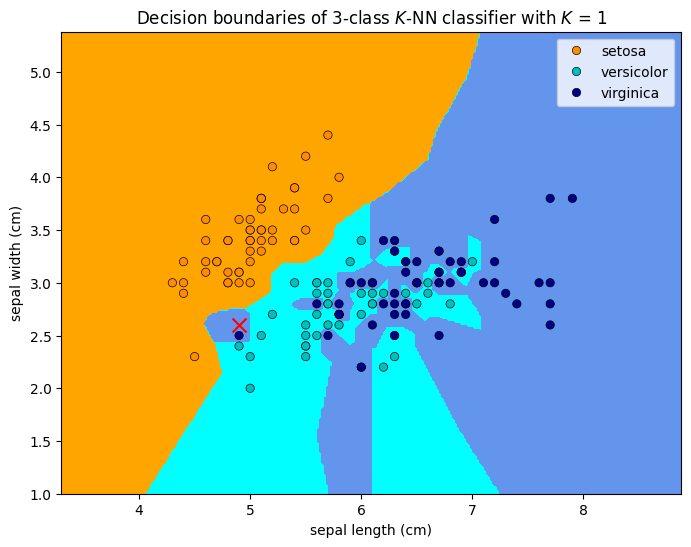

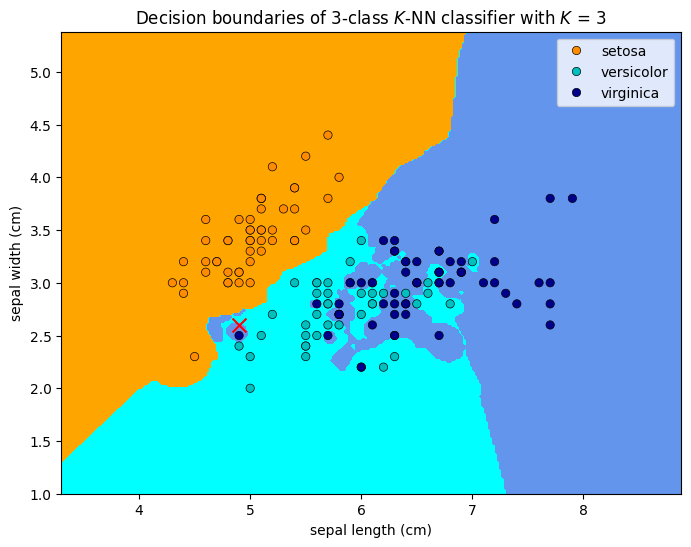

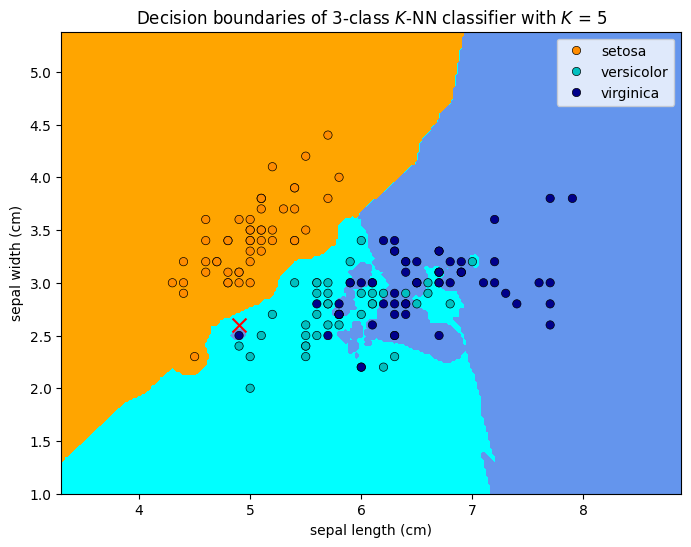

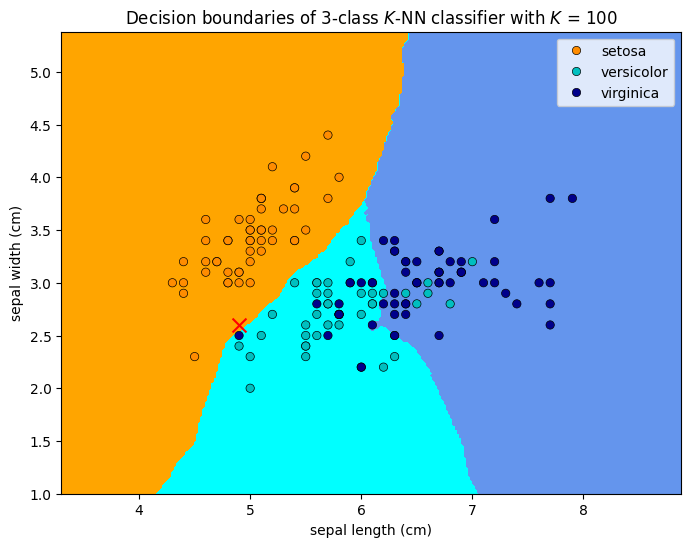

In [ ]:
for n_neighbors in [1, 3, 5, 15, 50, 100]:
  # We create an instance of Neighbours Classifier and fit the data.
  clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
  clf.fit(X, y)
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.figure(figsize=(8, 6))
  plt.contourf(xx, yy, Z, cmap=cmap_light)

  # Plot also the training points
  sns.scatterplot(
      x=X[:, 0],
      y=X[:, 1],
      hue=iris.target_names[y],
      palette=cmap_bold,
      alpha=1.0,
      edgecolor='black'
  )

  # Add an example data point for insights
  plt.scatter(4.9, 2.6, marker='x', color='red', s=100)

  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

  plt.title(f"Decision boundaries of 3-class $K$-NN classifier with $K$ = {n_neighbors}")

  plt.xlabel(iris.feature_names[0])
  plt.ylabel(iris.feature_names[1])

plt.show()



### System transparency
When $K$ = 5, the model predicts the test point to be a versicolor because  the majority of the five nearest neighbors to the red cross are _versicolor_ (green circles). When $K$ = 15, the model predicts the test point to be a setosa because the majority of the 15 nearest neighbours to the red cross are setosa (orange circles).

### Observations

* We can see that the decision boundaries are not smooth. This is because the $K$-NN model is a _non-parametric model_, which means that it does not make any assumption on the underlying data distribution. This is also the reason why the model is called ___lazy___. **K-NN actually does not learn a discriminative function from the training data but memorises the training data instead. This is why the model is called _instance-based_.** The model makes prediction by comparing the test sample with __all training samples__ and assigning the ___label that is most common among its K nearest neighbours.___

* _K_-NN is __fully transparent__ in the sense that it is easy to understand the logic behind the model and we can answer the question of for what values of the input variables would the system return a specific value of interest. However, it is not efficient in terms of computational cost. The computational cost of _K_-NN is _$O(n)$_, where $n$ is the number of training samples. This is because the model needs to compute the distance between the test sample and all training samples. This is also the reason why $K$-NN is not suitable for large datasets.

* Bias-variance trade-off: Choosing the correct level of flexibility (typically through _hyperparameter_ tunning after selecting a model) is critical to the success of any machine learning method.

In [ ]:
from sklearn import neighbors, datasets

iris = datasets.load_iris()
print(f"The number of features of iris dataset is {iris.data.shape[1]}")

The number of features of iris dataset is 4


In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame()

In [ ]:
data = dict(
    Observations=[1, 2, 3, 4, 5, 6],
    X1=[0, 2, 0, 0, -1, 1],
    X2=[3, 0, 1, 1, 0, -1],
    X3=[0, 0, 3, 2, 1, 1],
    Y=['Red', 'Red', 'Red', 'Green', 'Green', 'Red']
)


In [ ]:
data

{'Observations': [1, 2, 3, 4, 5, 6],
 'X1': [0, 2, 0, 0, -1, 1],
 'X2': [3, 0, 1, 1, 0, -1],
 'X3': [0, 0, 3, 2, 1, 1],
 'Y': ['Red', 'Red', 'Red', 'Green', 'Green', 'Red']}

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df

Observations  X1  X2  X3      Y
0             1   0   3   0    Red
1             2   2   0   0    Red
2             3   0   1   3    Red
3             4   0   1   2  Green
4             5  -1   0   1  Green
5             6   1  -1   1    Red

In [ ]:
# Compute Euclidean distance between each observation and the test pont
# X1 = 1, X2 = 1, X3 = 1
df['dist_1'] = df.apply(lambda row: np.sqrt((row['X1'] - 1)**2 + (row['X2'] - 1)**2 + (row['X3'] - 1)**2), axis=1)

In [ ]:
df

Observations  X1  X2  X3      Y    dist_1
0             1   0   3   0    Red  2.449490
1             2   2   0   0    Red  1.732051
2             3   0   1   3    Red  2.236068
3             4   0   1   2  Green  1.414214
4             5  -1   0   1  Green  2.236068
5             6   1  -1   1    Red  2.000000

In [ ]:
((0 - 1)**2 + (3-1)**2 + (0-1)**2) ** 0.5

2.449489742783178

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

df = pd.DataFrame(
    {
        'Obs': [1, 2, 3, 4, 5, 6],
        'X1': [0, 2, 0, 0, -1, 1],
        'X2': [3, 0, 1, 1, 0, -1],
        'X3': [0, 0, 3, 2, 1, 1],
        'Y': ['Red', 'Red', 'Red', 'Green', 'Green', 'Red']
    }
)

df

Obs  X1  X2  X3      Y
0    1   0   3   0    Red
1    2   2   0   0    Red
2    3   0   1   3    Red
3    4   0   1   2  Green
4    5  -1   0   1  Green
5    6   1  -1   1    Red

In [ ]:
def euclidean_dist(x, y=1):
  """Compute the row-wise euclidean distance from x to y."""
  return np.sqrt(np.sum((x - y)**2, axis=1))

In [ ]:
df.iloc[0, 1:-1]

X1    0
X2    3
X3    0
Name: 0, dtype: object

In [ ]:
euc_dist = pd.DataFrame({'EuclideanDist': euclidean_dist(df[['X1', 'X2', 'X3']])})
euc_dist

EuclideanDist
0       2.449490
1       1.732051
2       2.236068
3       1.414214
4       2.236068
5       2.000000

In [ ]:
df_euc = pd.concat([df, euc_dist], axis=1)
df_euc

Obs  X1  X2  X3      Y  EuclideanDist
0    1   0   3   0    Red       2.449490
1    2   2   0   0    Red       1.732051
2    3   0   1   3    Red       2.236068
3    4   0   1   2  Green       1.414214
4    5  -1   0   1  Green       2.236068
5    6   1  -1   1    Red       2.000000

In [ ]:
df_euc.reset_index(drop=True)

Obs  X1  X2  X3      Y  EuclideanDist
0    1   0   3   0    Red       2.449490
1    2   2   0   0    Red       1.732051
2    3   0   1   3    Red       2.236068
3    4   0   1   2  Green       1.414214
4    5  -1   0   1  Green       2.236068
5    6   1  -1   1    Red       2.000000

In [ ]:
# What is the prediction with K = 1? Why?
K = 1

df_euc.nsmallest(K, "EuclideanDist")

# Our prediction for K = 1 is Green

Obs  X1  X2  X3      Y  EuclideanDist
3    4   0   1   2  Green       1.414214

In [ ]:
# For K = 3
df_euc.nsmallest(3, "EuclideanDist")

Obs  X1  X2  X3      Y  EuclideanDist
3    4   0   1   2  Green       1.414214
1    2   2   0   0    Red       1.732051
5    6   1  -1   1    Red       2.000000

In [ ]:
# For K = 4
df_euc.nsmallest(4, "EuclideanDist")

Obs  X1  X2  X3      Y  EuclideanDist
3    4   0   1   2  Green       1.414214
1    2   2   0   0    Red       1.732051
5    6   1  -1   1    Red       2.000000
2    3   0   1   3    Red       2.236068

## Real Estate Price Prediction using Python

In [ ]:
import pandas as pd

# Load the dataset
real_estate_data = pd.read_csv("https://statso.io/wp-content/uploads/2023/12/Real_Estate.csv")

# Display the frist few rows of teh dataset and info
real_estate_data.head()

Transaction date  House age  Distance to the nearest MRT station  \
0  2012-09-02 16:42:30.519336       13.3                            4082.0150   
1  2012-09-04 22:52:29.919544       35.5                             274.0144   
2  2012-09-05 01:10:52.349449        1.1                            1978.6710   
3  2012-09-05 13:26:01.189083       22.2                            1055.0670   
4  2012-09-06 08:29:47.910523        8.5                             967.4000   

   Number of convenience stores   Latitude   Longitude  \
0                             8  25.007059  121.561694   
1                             2  25.012148  121.546990   
2                            10  25.003850  121.528336   
3                             5  24.962887  121.482178   
4                             6  25.011037  121.479946   

   House price of unit area  
0                  6.488673  
1                 24.970725  
2                 26.694267  
3                 38.091638  
4                 21.654710

In [ ]:
real_estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Transaction date                     414 non-null    object 
 1   House age                            414 non-null    float64
 2   Distance to the nearest MRT station  414 non-null    float64
 3   Number of convenience stores         414 non-null    int64  
 4   Latitude                             414 non-null    float64
 5   Longitude                            414 non-null    float64
 6   House price of unit area             414 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 22.8+ KB


In [ ]:
real_estate_data.columns.tolist()

['Transaction date',
 'House age',
 'Distance to the nearest MRT station',
 'Number of convenience stores',
 'Latitude',
 'Longitude',
 'House price of unit area']

In [ ]:
# Does the data contains any null values
real_estate_data.isnull().sum()

Transaction date                       0
House age                              0
Distance to the nearest MRT station    0
Number of convenience stores           0
Latitude                               0
Longitude                              0
House price of unit area               0
dtype: int64

In [ ]:
# Descriptive statistics of the dataset
descriptive_stats = real_estate_data.describe()
descriptive_stats

House age  Distance to the nearest MRT station  \
count  414.000000                           414.000000   
mean    18.405072                          1064.468233   
std     11.757670                          1196.749385   
min      0.000000                            23.382840   
25%      9.900000                           289.324800   
50%     16.450000                           506.114400   
75%     30.375000                          1454.279000   
max     42.700000                          6306.153000   

       Number of convenience stores    Latitude   Longitude  \
count                    414.000000  414.000000  414.000000   
mean                       4.265700   24.973605  121.520268   
std                        2.880498    0.024178    0.026989   
min                        0.000000   24.932075  121.473888   
25%                        2.000000   24.952422  121.496866   
50%                        5.000000   24.974353  121.520912   
75%                        6.750000   24.994947  121.544676   
max                       10.000000   25.014578  121.565321   

       House price of unit area  
count                414.000000  
mean                  29.102149  
std                   15.750935  
min                    0.000000  
25%                   18.422493  
50%                   30.394070  
75%                   40.615184  
max                   65.571716

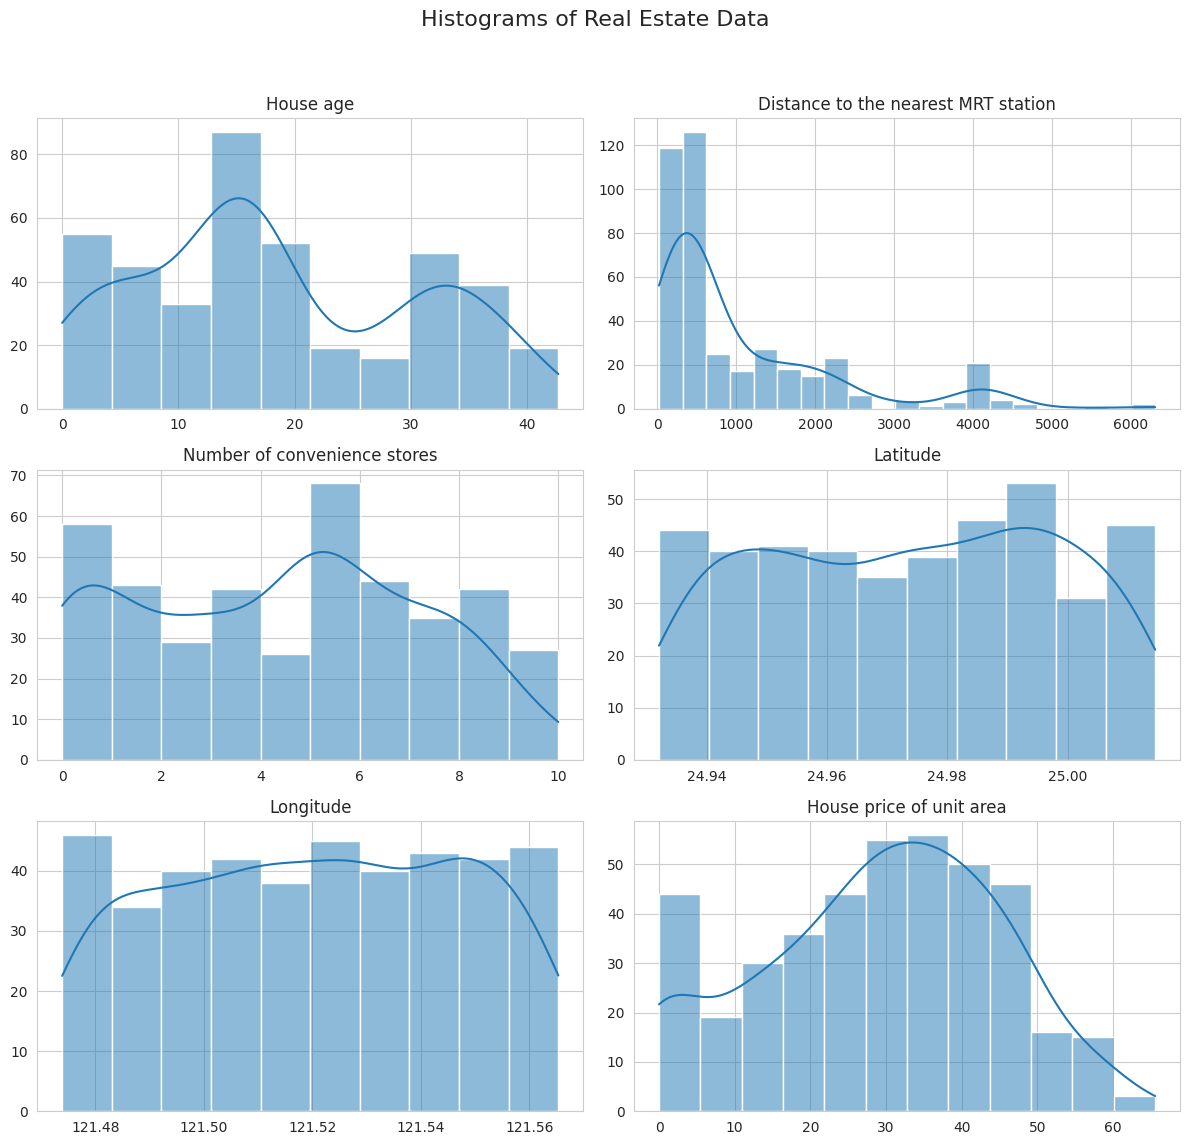

In [ ]:
# Now let's have a look at the histograms of all the numerical features

import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plot
sns.set_style('whitegrid')

# Create histograms for the numerical cols
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
fig.suptitle('Histograms of Real Estate Data', fontsize=16)

cols = real_estate_data.columns[1:].tolist()

for i, col in enumerate(cols):
  sns.histplot(real_estate_data[col], kde=True, ax=axes[i//2, i%2])
  axes[i//2, i%2].set_title(col)
  axes[i//2, i%2].set_xlabel('')
  axes[i//2, i%2].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Next, I'll create scatter plots to explore the relationships between these variables and the house price. It will help us understand which factors might be influencing property prices more significantly.

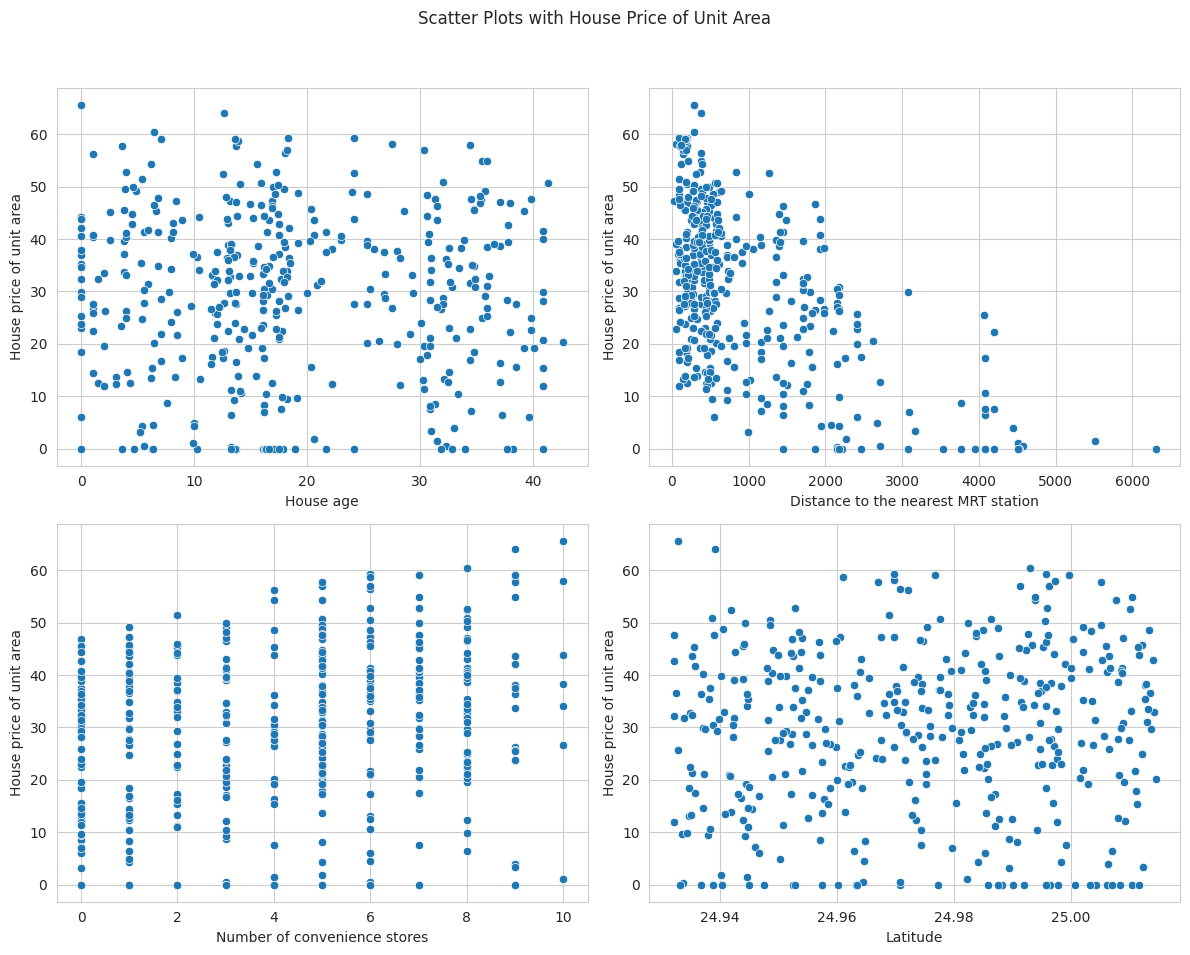

In [ ]:
# Scatter plots to observe the relationship with house price
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Scatter Plots with House Price of Unit Area')

# Scatter plot for each variable against the house price
sns.scatterplot(data=real_estate_data, x='House age', y='House price of unit area', ax=axes[0, 0])
sns.scatterplot(data=real_estate_data, x='Distance to the nearest MRT station', y='House price of unit area', ax=axes[0,1])
sns.scatterplot(data=real_estate_data, x='Number of convenience stores', y='House price of unit area', ax=axes[1,0])
sns.scatterplot(data=real_estate_data, x='Latitude', y='House price of unit area', ax=axes[1, 1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

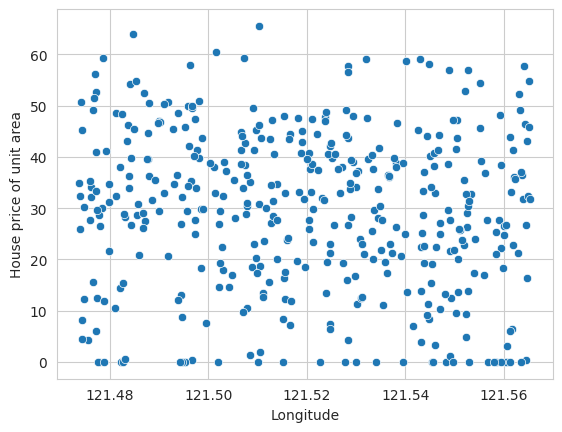

In [ ]:
sns.scatterplot(data=real_estate_data, x='Longitude', y='House price of unit area')
plt.show()

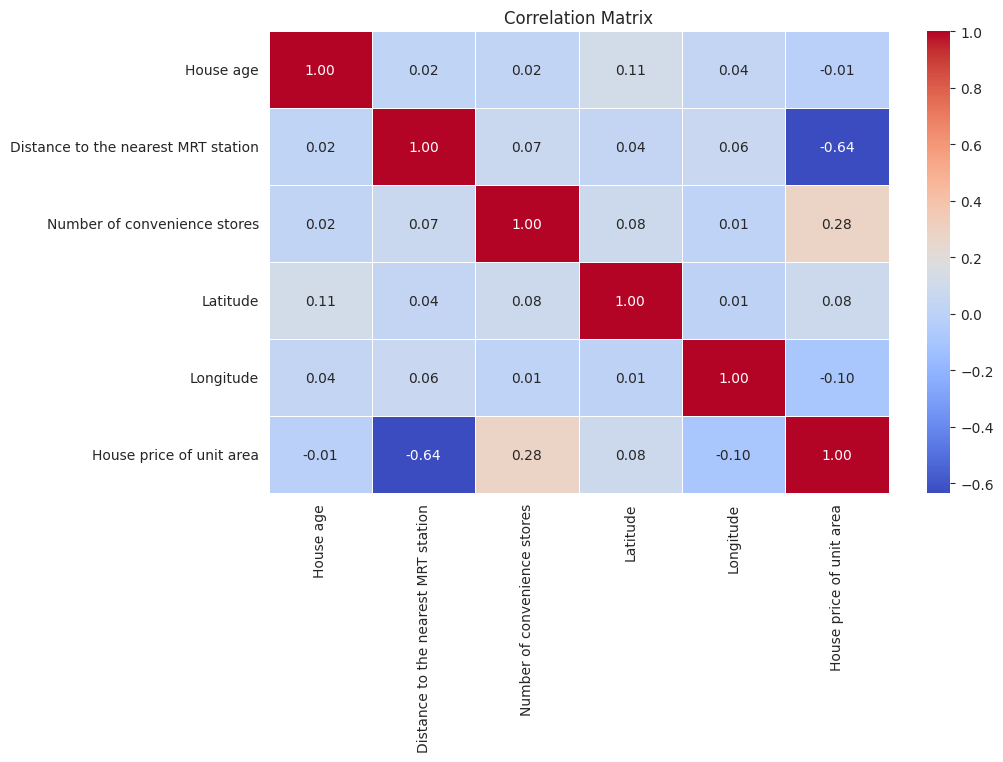

In [ ]:
# Correlation matrix
correlation_matrix = real_estate_data.corr(numeric_only=True)

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()



In [ ]:
correlation_matrix

House age  \
House age                             1.000000   
Distance to the nearest MRT station   0.021596   
Number of convenience stores          0.021973   
Latitude                              0.114345   
Longitude                             0.036449   
House price of unit area             -0.012284   

                                     Distance to the nearest MRT station  \
House age                                                       0.021596   
Distance to the nearest MRT station                             1.000000   
Number of convenience stores                                    0.069015   
Latitude                                                        0.038954   
Longitude                                                       0.064229   
House price of unit area                                       -0.636579   

                                     Number of convenience stores  Latitude  \
House age                                                0.021973  0.114345   
Distance to the nearest MRT station                      0.069015  0.038954   
Number of convenience stores                             1.000000  0.082725   
Latitude                                                 0.082725  1.000000   
Longitude                                                0.013156  0.007754   
House price of unit area                                 0.280763  0.081008   

                                     Longitude  House price of unit area  
House age                             0.036449                 -0.012284  
Distance to the nearest MRT station   0.064229                 -0.636579  
Number of convenience stores          0.013156                  0.280763  
Latitude                              0.007754                  0.081008  
Longitude                             1.000000                 -0.098626  
House price of unit area             -0.098626                  1.000000

The correlation matrix shows that the most significant factors affecting house prices in this dataset appear to be the _proximity to MRT statons and the number of convenience stores nearby_. The _geographical location (latitude and longitude) and the age of the house_ seem to have less impact on the price.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error, r2_score

# Selecting features and target variable
features = ['Distance to the nearest MRT station',
            'Number of convenience stores',
            'Latitude',
            'Longitude']

target = 'House price of unit area'

X = real_estate_data[features]
y = real_estate_data[target]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initialization
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

LinearRegression()

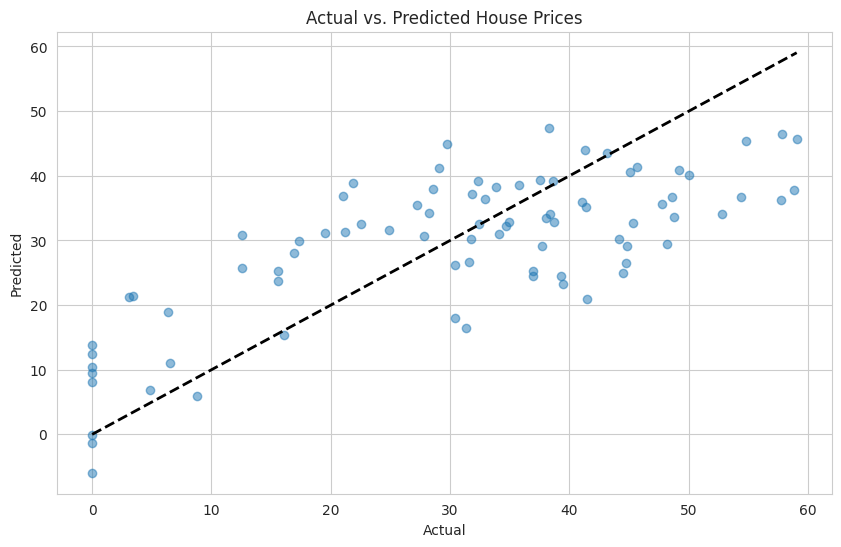

In [ ]:
# Making predictions using the linear regression model
y_pred_lr = model.predict(X_test)

# Visualization: Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted House Prices')
plt.show()

In [ ]:
mean_squared_error(y_test, y_pred_lr)

124.57938927549698

In [ ]:
r2_score(y_test, y_pred_lr)

0.5496730640943475

0.06061070366143284

## Summary

Real Estate Price Prediction is the process of estimating or forecasting the future prices of real estate properties, such as houses, apartments, or commercial buildings. The goal is to provide accurate property rates to buyers, sellers, investors, and real estate professionals to make informed decisions about real estate transactions.

In [ ]:
!pip install IMDbPY

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.2/297.2 kB 2.2 MB/s eta 0:00:00


In [ ]:
[e*e for e in range(20) if e % 2 == 0]

[0, 4, 16, 36, 64, 100, 144, 196, 256, 324]

In [ ]:
a = (e * e for e in range(20) if e % 2 == 0)
a

<generator object <genexpr> at 0x7b018c258350>

In [ ]:
next(a)

0

In [ ]:
next(a)

4

In [ ]:
next(a)

16

In [ ]:
list(a)

[36, 64, 100, 144, 196, 256, 324]

In [ ]:
a = ["a", "f", "bar", "b", "a", "aaaaa"]
ind = {a[i]: i for i in range(len(a))}
ind

{'a': 4, 'f': 1, 'bar': 2, 'b': 3, 'aaaaa': 5}

In [ ]:
ind['b']

3

In [ ]:
ind['a']

4

In [ ]:
ind['bar']

2

In [ ]:
ind = {val: i for (i, val) in enumerate(a)}
ind

{'a': 4, 'f': 1, 'bar': 2, 'b': 3, 'aaaaa': 5}

In [ ]:
fun_list1 = []
for i in range(5):
  def fun1(e):
    return e + i
  fun_list1.append(fun1)

In [ ]:
fun_list1

[<function __main__.fun1(e)>,
 <function __main__.fun1(e)>,
 <function __main__.fun1(e)>,
 <function __main__.fun1(e)>,
 <function __main__.fun1(e)>]

In [ ]:
fun_list1[0](10)

14

In [ ]:
fun_list1[1](10)

14

In [ ]:

id(fun_list1[0]) == id(fun_list1[1])

False

In [ ]:
fun_list1[0](1)

5

In [ ]:
fun_list1[1](1)

5

In [ ]:
fun_list2 = []
for i in range(5):
  def fun2(e, iv=i):
    return e + iv
  fun_list2.append(fun2)

In [ ]:

fun_list2[0](10)

10

In [ ]:
fun_list2[1](10)

11

In [ ]:
fun_list3 = [lambda e: e+i for i in range(5)]
fun_list4 = [lambda e, iv=i: e+iv for i in range(5)]

In [ ]:
ans = [fun_list3[i](10) for i in range(5)]
ans

[14, 14, 14, 14, 14]

In [ ]:
ans = [fun_list4[i](10) for i in range(5)]
ans

[10, 11, 12, 13, 14]

In [ ]:

ans = [fun_list4[i](e=10, iv=i*i) for i in range(0, 5)]
ans

[10, 11, 14, 19, 26]

In [ ]:
[10 + i*i for i in range(5)]

[10, 11, 14, 19, 26]

In [ ]:
[i*i for i in range(5)]

[0, 1, 4, 9, 16]

In [ ]:
def myrange(start, stop, step=1):
  """enumerates the values from start in steps of size step that are
  less than stop.
  """
  assert step > 0, f"only positive steps implemented in myrange: {step}"
  i = start
  while i < stop:
    yield i
    i += step

In [ ]:
list(myrange(2, 30, 3))

[2, 5, 8, 11, 14, 17, 20, 23, 26, 29]

In [ ]:
a_to_b = myrange(2, 30, 3)

In [ ]:
next(a_to_b)

2

In [ ]:
next(a_to_b)

5

In [ ]:
next(a_to_b)

8

In [ ]:
a_to_b = myrange(2.0, 30.0, 3.5)

In [ ]:
list(a_to_b)

[2.0, 5.5, 9.0, 12.5, 16.0, 19.5, 23.0, 26.5]

In [ ]:

def myrange(start, stop=None, step=1):
  """enumerates the values from start in steps of size step that are
  less than stop.
  """
  assert step > 0, f"only positive steps implemented in myrange: {step}"
  if stop is None:
    stop = start
    start = 0
  i = start
  while i < stop:
    yield i
    i += step

In [ ]:
a_to_b = myrange(30, step=3)

In [ ]:
list(a_to_b)

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In [19]:
def myrange(start, stop=None, step=1):
  if step < 0:
    if stop is None:
      stop = 0

    i = start
    while i > stop:
      yield i
      i += step
  else:
    if stop is None:
      stop = start
      start = 0

    i = start
    while i < stop:
      yield i
      i += step




In [20]:
a = myrange(2, 30, 3)
list(a)

[2, 5, 8, 11, 14, 17, 20, 23, 26, 29]

In [21]:
a = myrange(10)
list(a)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [22]:
a = myrange(10, step=2)
list(a)

[0, 2, 4, 6, 8]

In [23]:
b = myrange(10, step=-1)
list(b)

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [24]:
b = myrange(10, 0, -1)
list(b)

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [25]:
b = myrange(10, -1, -1)
list(b)

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [26]:

def ga(n):
  """
  Generates square of even nonnegative integers less than n
  """
  for e in range(n):
    if e % 2 == 0:
      yield e * e

a = ga(20)

In [27]:
list(a)

[0, 4, 16, 36, 64, 100, 144, 196, 256, 324]

In [28]:

def myenumerate(enum):
  for i in range(len(enum)):
    yield i, enum[i]

In [29]:

d = myenumerate(['a','b', 'c'])
next(d)

(0, 'a')

In [30]:
list(d)

[(1, 'b'), (2, 'c')]

In [31]:
def myenumerate(enum):
  i = 0
  for e in enum:
    yield i, e
    i += 1

In [32]:
d = myenumerate(['a','b', 'c'])
list(d)

[(0, 'a'), (1, 'b'), (2, 'c')]

In [33]:
import time

start_time = time.perf_counter()

ans = list(myrange(0, 1_000_000_00, 1))

end_time = time.perf_counter()

print(f"Time: {end_time - start_time} seconds")


Time: 17.344143309999936 seconds


In [34]:
import matplotlib.pyplot as plt

In [35]:
def myplot(minv, maxv, step, fun1, fun2):
  plt.ion() # make it interactive
  plt.xlabel("The x axis")
  plt.ylabel("The y axis")
  plt.xscale('linear') # Makes a 'log' or 'linear' scale
  xvalues = range(minv, maxv, step)
  plt.plot(xvalues, [fun1(x) for x in xvalues], label='The first fun')
  plt.plot(xvalues, [fun2(x) for x in xvalues], label=fun2.__doc__) # use the doc string of the function
  plt.legend(loc='upper right') # display the legend

def slin(x):
  """y = 2x+7"""
  return 2*x + 7

def sqfun(x):
  """y = (x - 40)^2 / 10 - 20"""
  return (x - 40)**2 / 10 - 20




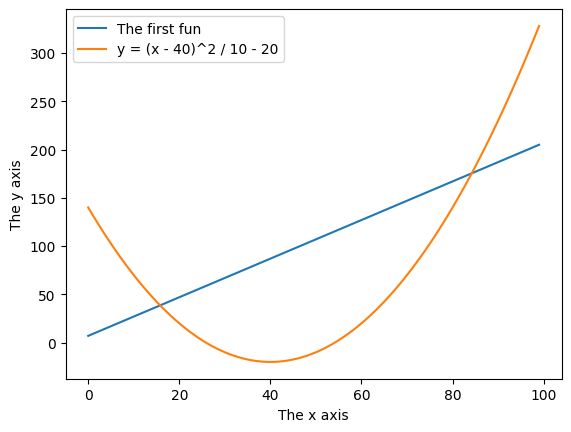

In [36]:
myplot(0, 100, 1, slin, sqfun)
plt.legend(loc='best');

In [38]:
import math

plt.plot([41 + 40*math.cos(th/10) for th in range(50)],
         [100 + 100*math.sin(th/10) for th in range(50)])

plt.text(40, 100, "ellipse")
plt.xscale('log');

In [39]:
class Displayable(object):
  """Class that uses 'display'.
  The amount of detail is controlled by max_display_level
  """
  max_display_level = 1 # can be overridden in subclasses or instances

  def display(self, level, *args, **nargs):
    """print the arguments if level is less than or equal to
    the current max_display_level.
    level is an integer.
    the other arguments are whatever arguments print can take.
    """
    if level <= self.max_display_level:
      print(*args, **nargs) ## if error you are using Python 2 not Python 3.



In [40]:
import random
import math

def argmaxall(gen):
  """gen is a generator of (element, value) pairs, where value is a real.
  argmaxall returns a list of all of the elements with maximal value.
  """
  maxv = -math.inf  # negative infinity
  maxvals = []  # list of maximal elements
  for (e, v) in gen:
    if v > maxv:
      maxvals, maxv = [e], v
    elif v == maxv:
      maxvals.append(e)
  return maxvals

def argmaxe(gen):
  """gen is a generator of (element, value) pairs, where value is a real.
  argmaxe returns an element with maximal value.
  If there are multiple elements with the max value, one is returned at random
  """
  return random.choice(argmaxall(gen))

def argmax(lst):
  """returns maximum index in a list"""
  return argmaxe(enumerate(lst))

def argmaxd(dct):
  """returns the arg max of a dictionary dct"""
  return argmaxe(dct.items())

In [41]:
argmax([1, 6, 3, 77, 3, 55, 23])

3

In [43]:
l = enumerate([1, 6, 3, 77, 3, 55, 23])
argmaxall(l)

[3]

In [46]:
argmax([1, 6, 3, 77, 3, 55, 23])

3

In [47]:
argmaxd({2:5, 5:9, 7:7, 8:10, 9:77})

9

In [48]:
argmaxe({2:5, 5:9, 7:7, 8:10, 9:77}.items())

9

In [49]:
# Change argmaxall to have an optional argument that specifies whether
# you want the “first”, “last” or a “random” index of the maximum value returned.
# If you want the first or the last, you don’t need to keep a list of the maximum
# elements. Enable the other methods to have this optional argument.

def argmaxall(gen, mode=None):
  maxv = -math.inf
  maxvals = []
  for (e, v) in gen:
    if v > maxv:
      maxvals, maxv = [e], v
    elif v == maxv:
      maxvals.append(e)

  if mode == 'first':
    return maxvals[0]
  elif mode == 'last':
    return maxvals[-1]
  elif mode == 'random':
    return random.choice(maxvals)
  else:
    return maxvals

In [50]:
dct = {1:1, 2:6, 3:3, 4:77, 5:100, 6:55, 7:24, 8:100, 9:77, 10:2}
argmaxall(dct.items())

[5, 8]

In [51]:
argmaxall(dct.items(), mode='first')

5

In [52]:
argmaxall(dct.items(), mode='last')

8

In [53]:
argmaxall(dct.items(), mode='random')

8

In [54]:
def flip(prob):
  """return true with probability prob"""
  return random.random() < prob

In [55]:
def select_from_dist(item_prob_dist):
  """returns a value from a distribution.
  item_prob_dist is an item:probability dictionary, where the
  probabilities sum to 1.
  returns an item chosen in proportion to its probability.
  """
  ranreal = random.random()
  for (it, prob) in item_prob_dist.items():
    if ranreal < prob:
      return it
    else:
      ranreal -= prob
  raise RuntimeError(f"{item_prob_dist} is a not probability distribution")

In [56]:
def test():
  """Test part of utilities"""
  assert argmax([1, 6, 55, 3, 55, 23]) in [2, 4]
  print("Passed unit test in utilities")
  print("run test_aipython() to test (almost) everything")

In [57]:
test()

Passed unit test in utilities
run test_aipython() to test (almost) everything
